# Imports and constants

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import gridspec
from tqdm.notebook import tqdm
from os import listdir
from os.path import isfile, join
from collections import defaultdict, Counter
import pickle
import math
from typing import Optional, Union
from itertools import combinations
import random
from scipy.special import binom
from dataclasses import dataclass
import ast
from random import sample, seed


# Overall style settings for matplotlib and pandas
title_fsize = "12"
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams["font.size"] = "12"
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)

# Define a color palette for different models and groups
palette = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

# Map each model/group to a specific color
colors = {
    'AnthropicAI_claude-3-opus-20240229': palette[0],
    'GoogleAI_gemini-1.0-pro': palette[1],
    'MetaAI_llama-2-70b-f': palette[2],
    'OpenAI_gpt-4-1106-preview': palette[3],
    'MistralAI_mistral-large-latest': palette[4],
    'Med student': palette[5],
    'Professional': palette[6],
}

# Define human-readable labels for each model/group
labels = {
    '1 human solvers': 'individual physician',
    '5 human solvers': '5-physician ensemble',
    'CohereAI_command': 'Cohere command',
    'GoogleAI_text-bison': 'Google text-bison',
    'MetaAI_llama-2-70b-f': 'Llama 2 70B',
    'OpenAI_gpt-4': 'GPT-4',
    'Med student': 'Av. medical student',
    'Professional': 'Average physician',
    'Attending': 'Av. attending physician',
    'Resident': 'Av. resident physician',
    'AnthropicAI_claude-3-opus-20240229': 'Claude 3',
    'OpenAI_gpt-4-1106-preview': 'GPT-4',
    'GoogleAI_gemini-1.0-pro': 'Gemini Pro',
    'MistralAI_mistral-large-latest': 'Mistral Large'
}

MAX_N_DIAGS = 5

exp_settings = ['base_common', 
                'base_sct', 
                'base_personalization_common', 
                'base_personalization_sct', 
                'base_personalization_common_selfconsistent', 
                'base_personalization_sct_selfconsistent', 
                'base_personalization_sct_selfconsistent_fewshot', 
                'base_personalization_common_selfconsistent_fewshot', 
                'base_personalization_sct_fewshot', 
                'base_personalization_common_fewshot', 
                'base_sct_fewshot', 
                'base_common_fewshot', 
                'base_common_selfconsistent', 
                'base_sct_selfconsistent', 
                'base_sct_selfconsistent_fewshot', 
                'base_common_selfconsistent_fewshot']

# Function and class definitions

In [2]:

# Class definitions --------------------------------------------------

@dataclass
class MachineModel:
    org: str
    name: str
    parameters: dict

class User(object):
    """User object."""
    def __init__(self, user):
        # Dynamically set attributes from the user dictionary
        for key, value in user.items():
            setattr(self, key, value)

class Case(object):
    """Case object."""
    def __init__(self, case):
        # Dynamically set attributes from the case dictionary
        for key, value in case.items():
            setattr(self, key, value)

class Solve(object):
    """Solve object."""
    def __init__(self, solve):
        # Dynamically set attributes from the solve dictionary
        for key, value in solve.items():
            setattr(self, key, value)

class MachineSolve(object):
    """MachineSolve object."""
    def __init__(self, machinesolve):
        # Dynamically set attributes from the machinesolve dictionary
        for key, value in machinesolve.items():
            setattr(self, key, value)

class Collective(object):
    """
    A class to represent a collection of diagnoses and their associated weights.

    Attributes:
        pc_id (int): The patient case ID.
        pc_dxs (list): The list of possible diagnoses for the patient case.
        weights (list): The list of weights associated with each solve.
        solves (list): The list of solve objects.
        pos_weight_fn (function): A function to calculate the weight based on position.
        final_dxs_to_score (list): The list of final diagnoses with their scores.
        final_dxs (list): The list of final diagnoses.
        match_pos (int): The position of the match in final diagnoses.
    """

    def __init__(self, pc_id, pc_dxs, weights,
                 solves: list[Union[MachineSolve, Solve]], pos_weight_fn=None):
        """
        Initializes the Collective object with given parameters.

        Args:
            pc_id (int): The patient case ID.
            pc_dxs (list): The list of possible diagnoses for the patient case.
            weights (list): The list of weights associated with each solve.
            solves (list): The list of solve objects.
            pos_weight_fn (function, optional): A function to calculate the weight based on position.
        """
        self.pc_id = pc_id
        self.pc_dxs = pc_dxs
        self.solves = solves
        self.weights = weights
        self.pos_weight_fn = pos_weight_fn or _one_over_position
        self.final_dxs_to_score, self.final_dxs = self._gen_final_dxs()
        self.match_pos = get_match_pos(pc_dxs, self.final_dxs)

    def _gen_final_dxs(self, solves=None, weights=None, pos_weight_fn=None):
        """
        Generates the final diagnoses and their scores based on the solves and weights.

        Args:
            solves (list, optional): The list of solve objects. Defaults to the instance's solves.
            weights (list, optional): The list of weights. Defaults to the instance's weights.
            pos_weight_fn (function, optional): A function to calculate the weight based on position.
            Defaults to the instance's pos_weight_fn.

        Returns:
            tuple: A tuple containing two lists - final_dxs_to_score and final_dxs.
        """
        solves = solves or self.solves
        weights = weights or self.weights
        pos_weight_fn = pos_weight_fn or self.pos_weight_fn

        dx_to_score = Counter()
        for i, solve in enumerate(solves):
            weight = weights[i]
            for j, sdx in enumerate(solve.final_dxs[:MAX_N_DIAGS]):
                if not pd.isna(sdx) and np.isscalar(weight):
                    cur_score = pos_weight_fn(j) * weight
                    dx_to_score[sdx] += cur_score
                elif not pd.isna(sdx): 
                    cur_score = weight[j]
                    dx_to_score[sdx] += cur_score
                    
        final_dxs_to_score = []
        final_dxs = []
        for dx, score in dx_to_score.most_common():
            final_dxs_to_score.append((dx, score))
            final_dxs.append(dx)
        return final_dxs_to_score, final_dxs


# helper functions ----------------------------------------------------------------   
    
# Function to calculate the inverse of a position value
def _one_over_position(pos: int) -> float:
    return 1 / (pos + 1)

# Function to create a defaultdict of dicts
def create_dict_defaultdict():
    return defaultdict(dict)

def get_match_pos(intended_set, guessed_array):
    """
    Finds the position of the first match between the intended set and guessed array.

    Args:
        intended_set (set): The set of intended diagnoses.
        guessed_array (list): The list of guessed diagnoses.

    Returns:
        int: The index of the first match in guessed_array if found, otherwise -1.
    """
    try:
        if intended_set and guessed_array:
            for idx, guessed in enumerate(guessed_array):
                if guessed and guessed in intended_set:
                    return idx
        return -1
    except:
        return -1

# Define a function to convert instance to an ID
def instance_to_id(x):
    if isinstance(x, Solve):
        return x.id
    elif isinstance(x, MachineSolve):
        return x.llm_model + '_' + str(x.pc_id)
    
def round_matrix_to_sum(matrix, target_sum=100):
    # Flatten the matrix to make manipulation easier
    flat_matrix = matrix.flatten()
    
    # Scale the matrix so its sum equals the target_sum
    scaled_matrix = flat_matrix * (target_sum / flat_matrix.sum())
    
    # Round the values to the nearest integer
    rounded_matrix = np.round(scaled_matrix)
    
    # Calculate the difference caused by rounding
    difference = target_sum - rounded_matrix.sum()
    
    # Sort indices based on the decimal part of the scaled matrix
    decimal_part = scaled_matrix - np.floor(scaled_matrix)
    sorted_indices = np.argsort(decimal_part)
    
    # Adjust the rounded values to ensure the sum is exactly target_sum
    if difference > 0:
        for i in range(int(difference)):
            rounded_matrix[sorted_indices[-(i+1)]] += 1
    elif difference < 0:
        for i in range(int(-difference)):
            rounded_matrix[sorted_indices[i]] -= 1
    
    # Reshape the flat matrix back to the original shape
    rounded_matrix = rounded_matrix.reshape(matrix.shape)
    
    return rounded_matrix

def unique_to_list(series):
    """
    Returns unique values from the series as a single value if only one unique value exists,
    otherwise returns the unique values as a list.
    """
    unique_vals = series.unique()
    if len(unique_vals) == 1:
        return unique_vals[0]
    else:
        return series.tolist()

def to_list(series):
    """
    Converts a pandas Series to a list.
    """
    return series.tolist()

def find_first_true(boolean_input):
    """
    Finds the index of the first True value in a list of booleans.
    Returns 0 if the input is a single boolean value and True, -1 otherwise.
    """
    if not isinstance(boolean_input, list):
        return 0 if boolean_input else -1
    
    # Process as list
    for index, value in enumerate(boolean_input):
        if value:
            return index
    return -1


# Functions for processing data ----------------------------------------------------------------

def calculate_weights_wmve(mkey_list, m_exp_setting, case_ids, case_id_to_mkey_to_msolve, metric):
    """
    Calculate weighted mean voting ensemble (WMVE) weights based on a specified metric.

    Args:
        mkey_list (list): List of model keys.
        m_exp_setting (dict): Dictionary mapping model keys to their experimental settings.
        case_ids (list): List of case IDs.
        case_id_to_mkey_to_msolve (dict): Dictionary mapping case IDs to model keys and their solves.
        metric (str): Metric to use for weight calculation ('mrr', 'top5', 'top3', 'top1').

    Returns:
        dict: Normalized weights for each model key.
    """
    N = len(mkey_list)
    weights = {mkey: 1 for mkey in mkey_list}  # Initialize weights for each model key

    for cid in case_ids:
        # Get match positions for each model key for the current case ID
        mkey_to_matchpos = {mkey: case_id_to_mkey_to_msolve[cid][mkey][m_exp_setting[mkey]].match_pos for mkey in mkey_list}

        # Calculate scores based on the specified metric
        if metric == 'mrr':
            mkey_to_score = {mkey: 1 / (pos + 1) if 0 <= pos < 5 else 0 for mkey, pos in mkey_to_matchpos.items()}
        elif metric == 'top5':
            mkey_to_score = {mkey: 1 if 0 <= pos < 5 else 0 for mkey, pos in mkey_to_matchpos.items()}
        elif metric == 'top3':
            mkey_to_score = {mkey: 1 if 0 <= pos < 3 else 0 for mkey, pos in mkey_to_matchpos.items()}
        elif metric == 'top1':
            mkey_to_score = {mkey: 1 if 0 <= pos < 1 else 0 for mkey, pos in mkey_to_matchpos.items()}
        else:
            print('metric unknown')
            return None
        
        # Sum the scores for normalization
        correct_score = np.sum(list(mkey_to_score.values()))

        # Adjust weights based on the scores
        for mkey in mkey_list:
            weights[mkey] += mkey_to_score[mkey] * (N - correct_score) / N

    # Normalize the weights
    norm_all = np.sum(list(weights.values()))
    return {k: v / norm_all for k, v in weights.items()}

def process_machine_combo(
    mkey_list,
    m_exp_setting,
    m_case_ids_culled,
    case_id_to_mkey_to_msolve,
    mkey_to_weight,
    case_id_to_case,
    pos_weight_fn = _one_over_position,
    use_weights = True
):
    """
    Process a combination of machine models to generate collective solves.

    Args:
        mkey_list (list): List of model keys.
        m_exp_setting (dict): Dictionary mapping model keys to their experimental settings.
        m_case_ids_culled (list): List of case IDs to process.
        case_id_to_mkey_to_msolve (dict): Dictionary mapping case IDs to model keys and their solves.
        mkey_to_weight (dict): Dictionary mapping model keys to their weights.
        case_id_to_case (dict): Dictionary mapping case IDs to case details.
        pos_weight_fn (function): Function to calculate position weights.
        use_weights (bool): Flag to indicate whether to use weights.

    Returns:
        pd.DataFrame: DataFrame containing the collective solves.
    """
    print(f"Processing combo: {mkey_list}...")

    # Set weights based on the use_weights flag
    if use_weights: 
        m_weights = [mkey_to_weight[mkey] for mkey in mkey_list]
    else:
        m_weights = [1.0 for mkey in mkey_list]
        
    collective_solves = []

    # Process each case ID
    for case_id in m_case_ids_culled:
        mkey_to_msolve = case_id_to_mkey_to_msolve[case_id]
        case = case_id_to_case[case_id]
        case_diagnoses = case.sctids

        # Collect solves for each model key
        m_solves = []
        for mkey in mkey_list:
            m_solves.append(mkey_to_msolve[mkey][m_exp_setting[mkey]])
      
        # Create a Collective object for the case
        m_collective = Collective(
            pc_id=case_id,
            pc_dxs=case_diagnoses,
            weights=m_weights,
            solves=m_solves,
            pos_weight_fn= pos_weight_fn,
        )
        
        # Append the collective solve to the list
        collective_solves.append(vars(m_collective))

    # Convert the list of collective solves to a DataFrame
    return pd.DataFrame(collective_solves)

def calculate_weights_wmve_hybrid(mkey_list,
                                  m_exp_setting,
                                  case_ids,
                                  case_id_to_mkey_to_msolve,
                                  metric, 
                                  selectedcases_id_to_solves, 
                                  num_solvers,
                                  sample_n_combis=1,
                                  max_guesses_allowed=100):
    """
    Calculate weights for a hybrid ensemble of machine and human solvers using WMVE.

    Args:
        mkey_list (list): List of machine keys.
        m_exp_setting (dict): Dictionary mapping machine keys to their experimental settings.
        case_ids (list): List of case IDs.
        case_id_to_mkey_to_msolve (dict): Dictionary mapping case IDs to machine keys and their solves.
        metric (str): Metric to use for weight calculation ('mrr', 'top5', 'top3', 'top1').
        selectedcases_id_to_solves (dict): Dictionary mapping case IDs to solves.
        num_solvers (int): Number of human solvers to include.
        sample_n_combis (int): Number of combinations to sample.
        max_guesses_allowed (int): Maximum number of guesses allowed.

    Returns:
        dict: Normalized weights for each key.
    """
    N = len(mkey_list) + num_solvers  # Total number of keys (machine + human)
    weights = {mkey: 1 for mkey in mkey_list}  # Initialize weights for machine keys
    weights['av_human'] = 1  # Initialize weight for average human

    for cid in case_ids:
        # Get match positions for each machine key for the current case ID
        mkey_to_matchpos = {mkey: case_id_to_mkey_to_msolve[cid][mkey][m_exp_setting[mkey]].match_pos for mkey in mkey_list}
        potential_solves = selectedcases_id_to_solves[cid]
        human_solve_combis = sample_combinations(potential_solves, num_solvers, sample_n_combis, max_guesses_allowed)
        
        case_weights = {mkey: 0 for mkey in mkey_list}  # Initialize case weights for machine keys
        case_weights['av_human'] = 0  # Initialize case weight for average human

        # Calculate scores for each metric
        if metric == 'mrr':
            mkey_to_score = {mkey: 1 / (pos + 1) if 0 <= pos < 5 else 0 for mkey, pos in mkey_to_matchpos.items()}
        elif metric == 'top5':
            mkey_to_score = {mkey: 1 if 0 <= pos < 5 else 0 for mkey, pos in mkey_to_matchpos.items()}
        elif metric == 'top3':
            mkey_to_score = {mkey: 1 if 0 <= pos < 3 else 0 for mkey, pos in mkey_to_matchpos.items()}
        elif metric == 'top1':
            mkey_to_score = {mkey: 1 if 0 <= pos < 1 else 0 for mkey, pos in mkey_to_matchpos.items()}
        else:
            print('metric unknown')
            return None
        
        # Process human solves
        n_combis = len(human_solve_combis)
        
        for human_combi in human_solve_combis:
            for i, human_solve in enumerate(human_combi):
                pos = human_solve.match_pos
                if metric == 'mrr':
                    mkey_to_score[f'human{i}'] = 1 / (pos + 1) if 0 <= pos < 5 else 0
                elif metric == 'top5':
                    mkey_to_score[f'human{i}'] = 1 if 0 <= pos < 5 else 0 
                elif metric == 'top3':
                    mkey_to_score[f'human{i}'] = 1 if 0 <= pos < 3 else 0 
                elif metric == 'top1':
                    mkey_to_score[f'human{i}'] = 1 if 0 <= pos < 1 else 0 
                else:
                    print('metric unknown')
                    return None
                    
            # Calculate correct score and update case weights
            correct_score = np.sum(list(mkey_to_score.values()))
            for mkey in mkey_list:
                case_weights[mkey] += mkey_to_score[mkey] * (N - correct_score) / N / n_combis
            for i in range(num_solvers):
                case_weights['av_human'] += mkey_to_score[f'human{i}'] * (N - correct_score) / N / n_combis / num_solvers
                
        # Update overall weights
        for k, v in case_weights.items():
            weights[k] += v
            
    # Normalize the weights
    norm_all = np.sum(list(weights.values()))
    return {k: v / norm_all for k, v in weights.items()}



def sample_combinations(potential_solves, num_solvers, sample_n_combis, max_guesses_allowed):
    """
    Sample combinations of human solvers from the potential solves.

    Args:
        potential_solves (list): List of potential solves.
        num_solvers (int): Number of solvers to sample.
        sample_n_combis (int): Number of combinations to sample.
        max_guesses_allowed (int): Maximum number of guesses allowed.

    Returns:
        list: List of sampled combinations.
    """
    if len(potential_solves) < num_solvers or num_solvers == 0:
        return []
    
    combis = set()
    total_combinations = binom(len(potential_solves), num_solvers)  # Total possible combinations
    
    # If too many combinations, sample directly and ensure uniqueness
    if total_combinations > 10000:
        while len(combis) < min(sample_n_combis, total_combinations) and len(combis) < max_guesses_allowed:
            potential_combi = frozenset(sample(potential_solves, num_solvers))
            combis.add(potential_combi)
    else:
        all_combis = list(combinations(potential_solves, num_solvers))
        combis.update(sample(all_combis, min(sample_n_combis, len(all_combis))))

    return [list(combi) for combi in combis]

def process_hybrid_solves(
    mkey_list,
    m_exp_setting,
    num_solvers,
    m_case_ids_culled,
    key_to_weight,
    case_id_to_mkey_to_msolve,
    selectedcases_id_to_solves,
    case_id_to_case,
    sample_n_combis=5,
    max_guesses_allowed=100, 
    weights=True, 
):
    """
    Process hybrid solves combining machine and human solvers.

    Args:
        mkey_list (list): List of machine keys.
        m_exp_setting (dict): Dictionary mapping machine keys to their experimental settings.
        num_solvers (int): Number of human solvers to include.
        m_case_ids_culled (list): List of case IDs to process.
        key_to_weight (dict): Dictionary mapping keys to their weights.
        case_id_to_mkey_to_msolve (dict): Dictionary mapping case IDs to machine keys and their solves.
        selectedcases_id_to_solves (dict): Dictionary mapping case IDs to solves.
        case_id_to_case (dict): Dictionary mapping case IDs to case details.
        sample_n_combis (int): Number of combinations to sample.
        max_guesses_allowed (int): Maximum number of guesses allowed.
        weights (bool): Flag to indicate whether to use weights.

    Returns:
        pd.DataFrame: DataFrame containing the hybrid solves.
    """
    # Set weights for machine and human solvers
    if weights:
        m_weights = [key_to_weight[mkey] for mkey in mkey_list]
        h_weights = [key_to_weight['av_human'] for _ in range(num_solvers)]
    else:
        m_weights = [1.0 for _ in mkey_list]
        h_weights = [1.0 for _ in range(num_solvers)]
        
    collective_solves = []

    for case_id in m_case_ids_culled:
        case = case_id_to_case[case_id]  # Get case details
        
        # Collect machine solves for the current case
        m_solves = [case_id_to_mkey_to_msolve[case_id][mkey][m_exp_setting[mkey]] for mkey in mkey_list]

        potential_solves = selectedcases_id_to_solves[case_id]
        combis = sample_combinations(potential_solves, num_solvers, sample_n_combis, max_guesses_allowed)
        
        if len(combis) == 0:
            print(f"No combination found for case {case_id}, and {num_solvers} solvers")
            continue
        
        for combi in combis:
            combined_solves = m_solves + combi
            combined_weights = m_weights + h_weights
            h_collective = Collective(
                pc_id=case_id,
                pc_dxs=case.sctids,
                weights=combined_weights,
                solves=combined_solves,
                pos_weight_fn=_one_over_position,
            )
            collective_solves.append(vars(h_collective))               

    # Convert the collective solves to a DataFrame and drop unnecessary columns
    df = pd.DataFrame(collective_solves)
    df = df.drop(columns=['solves', 'weights', 'pos_weight_fn', 'final_dxs_to_score'])
    return df



# Load data

In [3]:

# Load case data

cases_df = pd.read_csv('data/case_data_matched.csv')
cases_df['diagnosis_names'] = cases_df['diagnosis_names'].apply(ast.literal_eval)
cases_df['sctids'] = cases_df['sctids'].apply(ast.literal_eval)
cases_dicts = cases_df.to_dict(orient='records')
case_id_to_case = {case['id']: Case(case) for case in cases_dicts}
cases_df = cases_df.set_index('id')

# Load solve data

# Read and process solve data
solves_df_expanded = pd.read_csv('data/solves_data_matched.csv')
solves_df_collapsed = solves_df_expanded.groupby('id').agg(
    {col: to_list if col in ['sctid', 'diagnosis', 'rank', 'is_correct']
     else unique_to_list for col in solves_df_expanded.columns if col != 'id' })

# Find the position of the first correct diagnosis
solves_df_collapsed['match_pos'] = solves_df_collapsed['is_correct'].apply(find_first_true)
solves_df_collapsed = solves_df_collapsed.rename(columns={'diagnosis': 'final_dxs_str', 'sctid': 'final_dxs'}).reset_index()
solves_dicts = solves_df_collapsed.to_dict(orient='records')

# Create a dictionary mapping solve IDs to Solve objects
solve_id_to_solve = {solve['id']: Solve(solve) for solve in solves_dicts}

# Load LLM data

llm_solves_df_expanded = pd.read_csv('data/llm_data_matched_validcases.csv')
llm_solves_df_expanded['sctid'] = llm_solves_df_expanded['sctid'].astype('Int64')
llm_solves_df_collapsed = llm_solves_df_expanded.groupby(['pc_id', 'llm_model', 'prompt']).agg(
    {col: to_list if col in ['sctid', 'diagnosis', 'rank', 'is_correct']
     else unique_to_list for col in llm_solves_df_expanded.columns if col not in ['prompt', 'llm_model', 'pc_id'] })

# Find the position of the first correct diagnosis
llm_solves_df_collapsed['match_pos'] = llm_solves_df_collapsed['is_correct'].apply(find_first_true)
llm_solves_df_collapsed.reset_index(inplace=True)
llm_solves_df_collapsed = llm_solves_df_collapsed.rename(columns={'diagnosis': 'final_dxs_str', 'sctid': 'final_dxs'})
llm_solves_dicts = llm_solves_df_collapsed.to_dict(orient='records')

# Create nested dictionary mapping case IDs, LLM models, and prompts to MachineSolve objects
case_id_to_mkey_to_msolve = defaultdict(create_dict_defaultdict)
for llm_solve in llm_solves_dicts:
    case_id_to_mkey_to_msolve[llm_solve['pc_id']][llm_solve['llm_model']][llm_solve['prompt']] = MachineSolve(llm_solve)

# Load user data
users_df = pd.read_csv('data/user_data.csv')
# Create a dictionary mapping user IDs to User objects
user_id_to_user = {user['_id']: User(user) for user in users_df.to_dict(orient='records')}

# Load case specialties
case_specialties = pickle.load(open('data/data_case_specialties.pkl', 'rb'))

## Filter and prepare data

In [4]:

few_shot_ids = [3004, 4810, 6473, 2730, 1898]  # Predefined list of few-shot IDs

case_id_to_solve_ids = defaultdict(set)  # Maps case IDs to sets of solve IDs
case_id_to_solver_ids = defaultdict(set)  # Maps case IDs to sets of solver IDs

# Populate case_id_to_solve_ids and case_id_to_solver_ids
for solve_id, solve in sorted(solve_id_to_solve.items()):
    case = case_id_to_case[solve.pc_id]
    not_creator_solve = solve.solver_id != case.creator_id # exclude creator solves
    not_resolve = solve.solver_id not in case_id_to_solver_ids[solve.pc_id] # exclude resolves
    if not_creator_solve and not_resolve:
        case_id_to_solver_ids[solve.pc_id].add(solve.solver_id)
        case_id_to_solve_ids[solve.pc_id].add(solve_id)

# Select case IDs with valid vignette text, not in few_shot_ids, and present in case_id_to_solve_ids
selectedcases_ids = [
    _id for _id in cases_df.index
    if ((_id not in cases_df[cases_df['vignette_text'].isna()].index)
        and (_id not in few_shot_ids)
        and (_id in case_id_to_solve_ids)
       )
]

# Map selected case IDs to their respective solves
selectedcases_id_to_solves = {
    cid: [solve_id_to_solve[sid] for sid in sids]
    for cid, sids in case_id_to_solve_ids.items()
    if cid in selectedcases_ids
}


# Filter cases_df to include only selected case IDs
selected_cases_df = cases_df[cases_df.index.isin(selectedcases_ids)]

# Create DataFrames for solves based on the role of the solver
medstudent_solves_df = pd.DataFrame(
    [vars(solve) for solves in selectedcases_id_to_solves.values() 
     for solve in solves if user_id_to_user[solve.solver_id].role_name == "Med student"]
)

professional_solves_df = pd.DataFrame(
    [vars(solve) for solves in selectedcases_id_to_solves.values() 
     for solve in solves if user_id_to_user[solve.solver_id].role_name in ["Attending", "Resident", "Fellow"]]
)

# Add columns to indicate if the match position is within the top 5, top 3, or top 1, and calculate MRR (Mean Reciprocal Rank)
medstudent_solves_df['top5'] = (medstudent_solves_df['match_pos'] < 5) & (medstudent_solves_df['match_pos'] >= 0)
medstudent_solves_df['top3'] = (medstudent_solves_df['match_pos'] < 3) & (medstudent_solves_df['match_pos'] >= 0)
medstudent_solves_df['top1'] = (medstudent_solves_df['match_pos'] < 1) & (medstudent_solves_df['match_pos'] >= 0)
medstudent_solves_df['mrr'] = medstudent_solves_df['match_pos'].map(lambda x: 1 / (x + 1) if x >= 0 else 0)

professional_solves_df['top5'] = (professional_solves_df['match_pos'] < 5) & (professional_solves_df['match_pos'] >= 0)
professional_solves_df['top3'] = (professional_solves_df['match_pos'] < 3) & (professional_solves_df['match_pos'] >= 0)
professional_solves_df['top1'] = (professional_solves_df['match_pos'] < 1) & (professional_solves_df['match_pos'] >= 0)
professional_solves_df['mrr'] = professional_solves_df['match_pos'].map(lambda x: 1 / (x + 1) if x >= 0 else 0)

# Calculate mean values of 'top5', 'top3', 'top1', and 'mrr' for each role group, grouped by 'pc_id'
means_medstudent = medstudent_solves_df.groupby('pc_id')[['top5', 'top3', 'top1', 'mrr']].mean().mean()
means_professional = professional_solves_df.groupby('pc_id')[['top5', 'top3', 'top1', 'mrr']].mean().mean()

# Map each solve to its case specialty for medical students and calculate mean performance metrics by specialty
medstudent_solves_df['case_specialty'] = medstudent_solves_df['pc_id'].map(lambda x: case_specialties[x][1][0])
# Group by case ID and specialty, calculate means, then group by specialty and calculate overall means
means_medstudent_specialty = medstudent_solves_df.groupby(['pc_id', 'case_specialty'])[['top5', 'top3', 'top1', 'mrr']].mean().reset_index().groupby('case_specialty').mean()

# Map each solve to its case specialty for professionals and calculate mean performance metrics by specialty
professional_solves_df['case_specialty'] = professional_solves_df['pc_id'].map(lambda x: case_specialties[x][1][0])
# Group by case ID and specialty, calculate means, then group by specialty and calculate overall means
means_professional_specialty = professional_solves_df.groupby(['pc_id', 'case_specialty'])[['top5', 'top3', 'top1', 'mrr']].mean().reset_index().groupby('case_specialty').mean()


min_solves = 5  # Minimum number of solves required per case

# Group medical student solves by case ID and filter cases with at least min_solves solves
medstudent_n_casesolves = medstudent_solves_df.groupby(by=['pc_id']).size()
medstudent_case_set_minn = set(medstudent_n_casesolves[medstudent_n_casesolves >= min_solves].index)

# Group professional solves by case ID and filter cases with at least min_solves solves
professional_n_casesolves = professional_solves_df.groupby(by=['pc_id']).size()
professional_case_set_minn = set(professional_n_casesolves[professional_n_casesolves >= min_solves].index)

# Filter solves by professionals for cases with at least min_solves solves
selectedcases_id_to_solves_profs_min5 = {}
for cid in professional_case_set_minn:
    selectedcases_id_to_solves_profs_min5[cid] = [
        solve for solve in selectedcases_id_to_solves[cid] 
        if user_id_to_user[solve.solver_id].role_name in ["Resident", "Attending", "Fellow"]
    ]

# Filter solves by medical students for cases with at least min_solves solves
selectedcases_id_to_solves_medstudents_min5 = {}
for cid in medstudent_case_set_minn:
    selectedcases_id_to_solves_medstudents_min5[cid] = [
        solve for solve in selectedcases_id_to_solves[cid] 
        if user_id_to_user[solve.solver_id].role_name == "Med student"
    ]



# LLM ensembles

### Prompt performance across cases

In [5]:
# List of model keys to be used
model_keys = [
    'OpenAI_gpt-4-1106-preview',
    'GoogleAI_gemini-1.0-pro',
    'AnthropicAI_claude-3-opus-20240229',
    'MetaAI_llama-2-70b-f',
    'MistralAI_mistral-large-latest'
]
mkey_to_mweight = {}
mkey_to_mweight['top5'] = defaultdict(dict)
mkey_to_mweight['top3'] = defaultdict(dict)
mkey_to_mweight['top1'] = defaultdict(dict)
mkey_to_mweight['mrr'] = defaultdict(dict)
for exp_setting in exp_settings:
    for model_key in model_keys:
        correct5 = 0
        correct3 = 0
        correct1 = 0
        mrr_score = 0
        total = 0
        for case_id in selectedcases_ids:
            machine_solve = case_id_to_mkey_to_msolve[case_id][model_key][exp_setting]
            if machine_solve.match_pos is not None:
                match_pos = machine_solve.match_pos
                if match_pos == -1:
                    match_pos = np.inf
                mrr_score += 1/(match_pos +1)
            if (machine_solve.match_pos is not None) and (0 <= machine_solve.match_pos < 1):
                correct5 += 1
                correct3 += 1
                correct1 += 1
            elif (machine_solve.match_pos is not None) and (0 <= machine_solve.match_pos < 3):
                correct5 += 1
                correct3 += 1
            elif (machine_solve.match_pos is not None) and (0 <= machine_solve.match_pos < 5):
                correct5 += 1
            total += 1
            mkey_to_mweight['top5'][model_key][exp_setting] = correct5 / total
            mkey_to_mweight['top3'][model_key][exp_setting] = correct3 / total
            mkey_to_mweight['top1'][model_key][exp_setting] = correct1 / total
            mkey_to_mweight['mrr'][model_key][exp_setting] = mrr_score / total

        
top1 = pd.DataFrame(mkey_to_mweight['top1'])
top3 = pd.DataFrame(mkey_to_mweight['top3'])
top5 = pd.DataFrame(mkey_to_mweight['top5'])
mrr = pd.DataFrame(mkey_to_mweight['mrr'])
# Concatenate the dataframes along the columns with keys to create a MultiIndex
prompt_performance_df = pd.concat([top1, top5, top3, mrr], axis=1, keys=["top1", "top5", "top3", "MRR"])

# Reorder the levels of the MultiIndex if needed (optional)
prompt_performance_df = prompt_performance_df.swaplevel(0, 1, axis=1).round(3)
# Sort the MultiIndex if needed (optional)
prompt_performance_df = prompt_performance_df.sort_index(axis=1).applymap(lambda x: '{:.3f}'.format(x))

prompt_performance_df.columns = prompt_performance_df.columns.map(lambda x: (labels[x[0]], x[1]))
#prompt performance
prompt_performance_df

Claude 3                \
                                                        MRR   top1   top3   
base_common                                           0.499  0.441  0.557   
base_sct                                              0.452  0.378  0.525   
base_personalization_common                           0.492  0.433  0.550   
base_personalization_sct                              0.454  0.379  0.526   
base_personalization_common_selfconsistent            0.500  0.440  0.562   
base_personalization_sct_selfconsistent               0.469  0.396  0.542   
base_personalization_sct_selfconsistent_fewshot       0.538  0.465  0.607   
base_personalization_common_selfconsistent_fewshot    0.557  0.491  0.621   
base_personalization_sct_fewshot                      0.542  0.471  0.606   
base_personalization_common_fewshot                   0.552  0.488  0.617   
base_sct_fewshot                                      0.549  0.477  0.619   
base_common_fewshot                                   0.558  0.494  0.621   
base_common_selfconsistent                            0.508  0.449  0.568   
base_sct_selfconsistent                               0.460  0.387  0.528   
base_sct_selfconsistent_fewshot                       0.541  0.467  0.612   
base_common_selfconsistent_fewshot                    0.554  0.489  0.618   

                                                          Gemini Pro         \
                                                     top5        MRR   top1   
base_common                                         0.584      0.386  0.338   
base_sct                                            0.564      0.405  0.334   
base_personalization_common                         0.578      0.390  0.343   
base_personalization_sct                            0.567      0.401  0.328   
base_personalization_common_selfconsistent          0.586      0.397  0.349   
base_personalization_sct_selfconsistent             0.579      0.413  0.341   
base_personalization_sct_selfconsistent_fewshot     0.649      0.465  0.403   
base_personalization_common_selfconsistent_fewshot  0.651      0.456  0.400   
base_personalization_sct_fewshot                    0.654      0.465  0.406   
base_personalization_common_fewshot                 0.647      0.449  0.395   
base_sct_fewshot                                    0.657      0.470  0.412   
base_common_fewshot                                 0.650      0.461  0.411   
base_common_selfconsistent                          0.594      0.390  0.345   
base_sct_selfconsistent                             0.571      0.423  0.353   
base_sct_selfconsistent_fewshot                     0.651      0.467  0.407   
base_common_selfconsistent_fewshot                  0.645      0.465  0.413   

                                                                 Llama 2 70B  \
                                                     top3   top5         MRR   
base_common                                         0.429  0.457       0.311   
base_sct                                            0.472  0.511       0.313   
base_personalization_common                         0.435  0.462       0.296   
base_personalization_sct                            0.472  0.515       0.305   
base_personalization_common_selfconsistent          0.442  0.469       0.303   
base_personalization_sct_selfconsistent             0.481  0.522       0.312   
base_personalization_sct_selfconsistent_fewshot     0.523  0.558       0.247   
base_personalization_common_selfconsistent_fewshot  0.504  0.545       0.285   
base_personalization_sct_fewshot                    0.519  0.556       0.231   
base_personalization_common_fewshot                 0.498  0.533       0.279   
base_sct_fewshot                                    0.523  0.559       0.228   
base_common_fewshot                                 0.508  0.539       0.271   
base_common_selfconsistent                          0.431  0.459       0.315   
base_sct_selfconsistent                  

### Performance of LLM ensembles

In [6]:
random.seed(12345)  # Set the seed for random number generation
np.random.seed(12345)  # Set the seed for numpy random number generation
folds = 5  # Number of folds for cross-validation

# Lists to store machine ensemble solve data
machine_ensemble_solve_data = []
machine_ensemble_solve_data_no_weights = []

# List of model keys to be used
model_keys = [
    'OpenAI_gpt-4-1106-preview',
    'GoogleAI_gemini-1.0-pro',
    'AnthropicAI_claude-3-opus-20240229',
    'MetaAI_llama-2-70b-f',
    'MistralAI_mistral-large-latest'
]

case_ids = selectedcases_ids  # Use selected case IDs
random.shuffle(case_ids)  # Shuffle case IDs randomly
ntrain = int(np.floor(len(case_ids) / folds))  # Number of training cases per fold

for j in range(folds):
    # Split case IDs into training and testing sets
    train_cids = case_ids[j * ntrain:j * ntrain + ntrain]
    test_cids = case_ids[:j * ntrain] + case_ids[j * ntrain + ntrain:]

    # Initialize dictionaries to store metrics for each model and experimental setting
    mkey_to_mweight = {'top5': defaultdict(dict), 'top3': defaultdict(dict), 'top1': defaultdict(dict), 'mrr': defaultdict(dict)}

    for exp_setting in exp_settings:
        for model_key in model_keys:
            correct5 = 0
            correct3 = 0
            correct1 = 0
            mrr_score = 0
            total = 0

            # Calculate metrics for each training case
            for case_id in train_cids:
                machine_solve = case_id_to_mkey_to_msolve[case_id][model_key][exp_setting]
                if machine_solve.match_pos is not None:
                    match_pos = machine_solve.match_pos
                    if match_pos == -1:
                        match_pos = np.inf
                    mrr_score += 1 / (match_pos + 1)
                if (machine_solve.match_pos is not None) and (0 <= machine_solve.match_pos < 1):
                    correct5 += 1
                    correct3 += 1
                    correct1 += 1
                elif (machine_solve.match_pos is not None) and (0 <= machine_solve.match_pos < 3):
                    correct5 += 1
                    correct3 += 1
                elif (machine_solve.match_pos is not None) and (0 <= machine_solve.match_pos < 5):
                    correct5 += 1
                total += 1

            # Store calculated metrics for the current model and experimental setting
            mkey_to_mweight['top5'][model_key][exp_setting] = correct5 / total
            mkey_to_mweight['top3'][model_key][exp_setting] = correct3 / total
            mkey_to_mweight['top1'][model_key][exp_setting] = correct1 / total
            mkey_to_mweight['mrr'][model_key][exp_setting] = mrr_score / total

    m_exp_setting = defaultdict(dict)
    mkey_to_score = defaultdict(dict)

    # Determine the best experimental setting for each metric and model key
    for metric in mkey_to_mweight.keys():
        for k, v in mkey_to_mweight[metric].items():
            best_key = ''
            best_val = 0
            for prompt, acc in v.items():
                if acc > best_val:
                    best_key = prompt
                    best_val = acc
            m_exp_setting[metric][k] = best_key
            mkey_to_score[metric][k] = best_val

    # Evaluate machine-only collectives
    combo_to_accuracy_w = defaultdict(dict)
    for metric in ['top5', 'top3', 'top1', 'mrr']:
        for i in range(1, len(model_keys) + 1):
            possible_combos = sorted(list(combinations(model_keys, i)))
            for mkey_list in possible_combos:

                # Calculate weights for each combination of model keys
                mkey_to_weight = calculate_weights_wmve(mkey_list, m_exp_setting[metric], train_cids, case_id_to_mkey_to_msolve, metric)

                # Process machine combo with weights
                collective_solves_df = process_machine_combo(
                    mkey_list,
                    m_exp_setting[metric],
                    m_case_ids_culled=test_cids,
                    case_id_to_mkey_to_msolve=case_id_to_mkey_to_msolve,
                    mkey_to_weight=mkey_to_weight,
                    case_id_to_case=case_id_to_case,
                    pos_weight_fn=_one_over_position
                )
                key = "|".join(mkey_list)
                collective_solves_df['fold'] = j
                collective_solves_df['metric'] = metric
                collective_solves_df['combo'] = key
                machine_ensemble_solve_data.append(collective_solves_df)

                # Process machine combo without weights
                collective_solves_df_no_weights = process_machine_combo(
                    mkey_list,
                    m_exp_setting[metric],
                    m_case_ids_culled=test_cids,
                    case_id_to_mkey_to_msolve=case_id_to_mkey_to_msolve,
                    mkey_to_weight={},
                    case_id_to_case=case_id_to_case,
                    pos_weight_fn=_one_over_position,
                    use_weights=False
                )
                collective_solves_df_no_weights['fold'] = j
                collective_solves_df_no_weights['metric'] = metric
                collective_solves_df_no_weights['combo'] = key
                machine_ensemble_solve_data_no_weights.append(collective_solves_df_no_weights)

# Combine all the collective solve data into a single DataFrame
machine_collective_df = pd.concat(machine_ensemble_solve_data)
machine_collective_df['top1'] = machine_collective_df['match_pos'] == 0
machine_collective_df['top3'] = (machine_collective_df['match_pos'] >= 0) & (machine_collective_df['match_pos'] < 3)
machine_collective_df['top5'] = (machine_collective_df['match_pos'] >= 0) & (machine_collective_df['match_pos'] < 5)
machine_collective_df['mrr'] = np.where(
    (machine_collective_df['match_pos'] >= 0) & (machine_collective_df['match_pos'] < 5),
    1 / (machine_collective_df['match_pos'] + 1), 0
)
machine_collective_df['case_specialty'] = machine_collective_df['pc_id'].map(lambda x: case_specialties[x][1][0])

# Combine all the collective solve data without weights into a single DataFrame
machine_collective_df_no_weights = pd.concat(machine_ensemble_solve_data_no_weights)
machine_collective_df_no_weights['top1'] = machine_collective_df_no_weights['match_pos'] == 0
machine_collective_df_no_weights['top3'] = (machine_collective_df_no_weights['match_pos'] >= 0) & (machine_collective_df_no_weights['match_pos'] < 3)
machine_collective_df_no_weights['top5'] = (machine_collective_df_no_weights['match_pos'] >= 0) & (machine_collective_df_no_weights['match_pos'] < 5)
machine_collective_df_no_weights['mrr'] = np.where(
    (machine_collective_df_no_weights['match_pos'] >= 0) & (machine_collective_df_no_weights['match_pos'] < 5),
    1 / (machine_collective_df_no_weights['match_pos'] + 1), 0
)
machine_collective_df_no_weights['case_specialty'] = machine_collective_df_no_weights['pc_id'].map(lambda x: case_specialties[x][1][0])

# Compute the mean performance metrics for the machine collective dataframe
machine_collective_means = machine_collective_df.reset_index().groupby(['metric', 'combo'])[['top1', 'top3', 'top5', 'mrr']].mean()
machine_collective_means.reset_index(inplace=True)

# Compute the mean performance metrics for each specialty in the machine collective dataframe
machine_collective_means_specialty = machine_collective_df.reset_index().groupby(['case_specialty', 'metric', 'combo'])[['top1', 'top3', 'top5', 'mrr']].mean()
machine_collective_means_specialty.reset_index(inplace=True)

# Compute the mean performance metrics for the machine collective dataframe without weights
machine_collective_means_no_weights = machine_collective_df_no_weights.reset_index().groupby(['metric', 'combo'])[['top1', 'top3', 'top5', 'mrr']].mean()
machine_collective_means_no_weights.reset_index(inplace=True)

# Calculate the difference in performance metrics between weighted and non-weighted means
machine_collective_weight_difference = (machine_collective_means.set_index(['combo', 'metric']) - machine_collective_means_no_weights.set_index(['combo', 'metric'])).reset_index()



i 0
j 0
Processing combo: ('AnthropicAI_claude-3-opus-20240229',)...
Processing combo: ('AnthropicAI_claude-3-opus-20240229',)...
Processing combo: ('GoogleAI_gemini-1.0-pro',)...
Processing combo: ('GoogleAI_gemini-1.0-pro',)...
Processing combo: ('MetaAI_llama-2-70b-f',)...
Processing combo: ('MetaAI_llama-2-70b-f',)...
Processing combo: ('MistralAI_mistral-large-latest',)...
Processing combo: ('MistralAI_mistral-large-latest',)...
Processing combo: ('OpenAI_gpt-4-1106-preview',)...
Processing combo: ('OpenAI_gpt-4-1106-preview',)...
Processing combo: ('AnthropicAI_claude-3-opus-20240229', 'MetaAI_llama-2-70b-f')...
Processing combo: ('AnthropicAI_claude-3-opus-20240229', 'MetaAI_llama-2-70b-f')...
Processing combo: ('AnthropicAI_claude-3-opus-20240229', 'MistralAI_mistral-large-latest')...
Processing combo: ('AnthropicAI_claude-3-opus-20240229', 'MistralAI_mistral-large-latest')...
Processing combo: ('GoogleAI_gemini-1.0-pro', 'AnthropicAI_claude-3-opus-20240229')...
Processing comb

In [7]:
# to table in paper
machine_collective_means_filtered = []
for metric in ['top1', 'top3', 'top5', 'mrr']:
    machine_collective_means_filtered.append(pd.DataFrame(machine_collective_means[machine_collective_means['metric']==metric].set_index('combo')[metric]))
machine_collective_means_filtered = pd.concat(machine_collective_means_filtered, axis=1)
machine_collective_means_filtered = machine_collective_means_filtered.apply(lambda col: col.round(decimals=3))
machine_collective_means_filtered.index = machine_collective_means_filtered.index.map(lambda x: '|'.join([labels[key] for key in x.split('|')]))
machine_collective_means_filtered.reset_index()

,combo,top1,top3,top5,mrr
0,Claude 3,0.487,0.618,0.650,0.553
1,Claude 3|Llama 2 70B,0.487,0.617,0.669,0.556
2,Claude 3|Llama 2 70B|Mistral Large,0.477,0.630,0.690,0.554
3,Claude 3|Mistral Large,0.487,0.628,0.684,0.558
4,Gemini Pro,0.408,0.519,0.554,0.464
5,Gemini Pro|Claude 3,0.486,0.633,0.693,0.562
6,Gemini Pro|Claude 3|Llama 2 70B,0.473,0.639,0.696,0.558
7,Gemini Pro|Claude 3|Llama 2 70B|Mistral Large,0.469,0.645,0.705,0.557
8,Gemini Pro|Claude 3|Mistral Large,0.474,0.643,0.703,0.561
9,Gemini Pro|Llama 2 70B,0.408,0.541,0.601,0.477


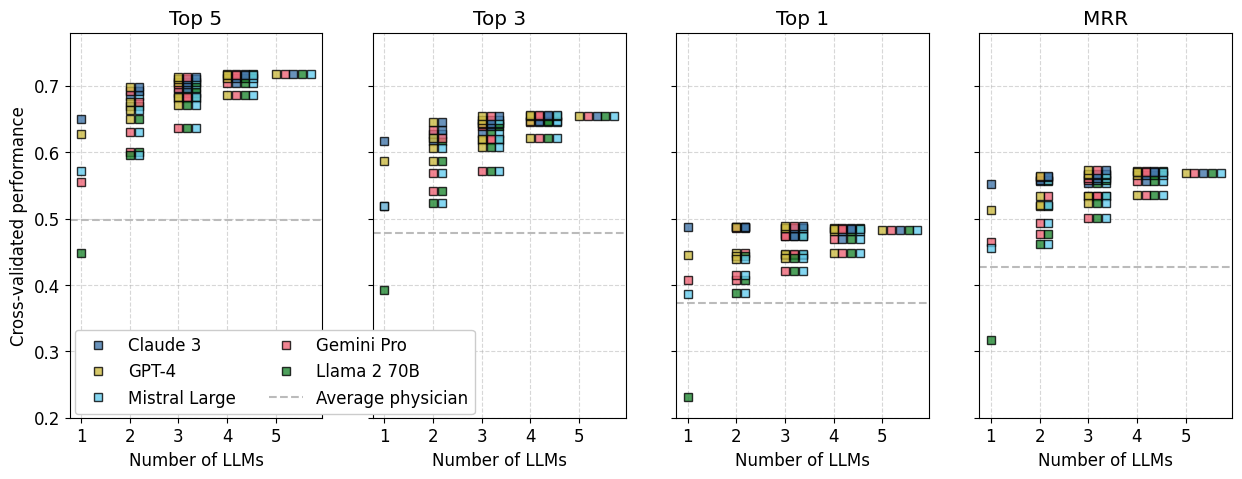

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
metric_label_dict = {"top5": "Top 5", "top3": "Top 3", "top1": "Top 1", "mrr": "MRR"}
for j,metric in enumerate(["top5", "top3", "top1", "mrr"]):
    plt.sca(axes[j])
    mean_dict =machine_collective_means[machine_collective_means['metric']==metric].set_index('combo').T.to_dict()
    for k,v in mean_dict.items():
        jitter = 0
        klist = k.split('|')
        for i,item in enumerate(klist):
            if len(klist)==1:
                plt.plot(jitter + len(klist)+0.18*i,v[metric], ms="6", marker = 's',linestyle='None', color=colors[item],
                         label = labels[item], markeredgecolor='black', alpha=0.8)
            else:
                plt.plot(jitter + len(klist)+0.18*i,v[metric], ms="6", marker = 's',linestyle='None',
                         color=colors[item], markeredgecolor='black', alpha=0.8)
    plt.xticks([1,2,3,4,5])
    plt.yticks([0.2,0.3,0.4, 0.5,0.6,0.7,0.8])
    plt.xlabel('Number of LLMs')
    

    plt.grid(axis='y', ls='--', alpha=0.5)
    plt.grid(axis='x', ls='--', alpha=0.5)
    plt.title(metric_label_dict[metric])

    plt.axhline(y=means_professional[metric], color=colors['Professional'], linestyle='--', label=labels['Professional'])
    if j==1:
        handles, legend_labels = axes[1].get_legend_handles_labels()
        order = [0,4,3,1,2,5]
        handles = [handles[idx] for idx in order]
        legend_labels = [legend_labels[idx] for idx in order]
        plt.legend(handles, legend_labels, loc=(-1.18,0.01), framealpha=1.0, ncol=2)
        
    if j==0:
        plt.ylabel('Cross-validated performance')
plt.ylim(0.2,0.78)
plt.savefig('./plots_nature/acc_metricgrid_weightedLLMs.png', bbox_inches='tight', format="png", dpi=300)
plt.show()

### Compare performance of LLM ensembles to physicians on the solver level

In [9]:
# How many humans are outperformed by LLM(s) (ensembles)

# Function to compare human solvers to a combination of models
def compare_to_combo(df, filtered_combo_df):
    # Keep only necessary columns to reduce memory usage
    relevant_columns = ['pc_id', 'match_pos']
    df = df[relevant_columns]
    df.rename(columns={'match_pos': 'match_pos_user'}, inplace=True)
    
    # Filter and prepare the combo DataFrame for comparison
    combo_relevant = filtered_combo_df[filtered_combo_df['pc_id'].isin(df['pc_id'])][relevant_columns]
    combo_relevant.rename(columns={'match_pos': 'match_pos_combo'}, inplace=True)
    
    # Merge user and combo results based on 'pc_id'
    comparison_df = pd.merge(df, combo_relevant, on='pc_id')
    
    # Replace -1 with infinity to handle unmatched cases
    comparison_df['match_pos_user'] = comparison_df['match_pos_user'].replace(-1, np.inf)
    comparison_df['match_pos_combo'] = comparison_df['match_pos_combo'].replace(-1, np.inf)
    
    # Determine the winner between user and combo for each case
    comparison_df['winner'] = np.where(
        comparison_df['match_pos_user'] < comparison_df['match_pos_combo'], 'user',
        np.where(comparison_df['match_pos_combo'] < comparison_df['match_pos_user'], 'combo', 'tie')
    )
    
    # Count the number of wins for each category
    win_counts = comparison_df['winner'].value_counts()
    return win_counts.to_dict()

min_solves = 5  # Minimum number of solves required per solver
performance_results_df = pd.DataFrame()  # DataFrame to store the results
combos = machine_collective_df['combo'].unique()  # List of unique combinations
metric = 'mrr'  # Metric to use for evaluation

# Loop through each fold and combo to evaluate performance
for fold in range(folds):
    for combo in combos:
        # Filter the machine collective DataFrame based on combo, metric, and fold
        filtered_combo_df = machine_collective_df[
            (machine_collective_df['combo'] == combo) &
            (machine_collective_df['metric'] == metric) &
            (machine_collective_df['fold'] == fold)
        ]
        case_ids = filtered_combo_df['pc_id'].unique()  # Get unique case IDs
        # Get solvers with at least min_solves solves
        relevant_solvers = solves_df_collapsed[solves_df_collapsed['pc_id'].isin(case_ids)].groupby('solver_id').size()
        relevant_solvers = relevant_solvers[relevant_solvers >= min_solves]
        # Filter solves DataFrame for relevant cases and solvers
        relevant_solves_df = solves_df_collapsed[
            solves_df_collapsed['pc_id'].isin(case_ids) & solves_df_collapsed['solver_id'].isin(relevant_solvers.index)
        ]

        # Apply the comparison function and store the results
        current_performance = relevant_solves_df.groupby('solver_id').apply(compare_to_combo, filtered_combo_df)
        current_performance = current_performance.reset_index(name='win_counts')
        current_performance['combo'] = combo
        current_performance['metric'] = metric
        current_performance['fold'] = fold

        # Concatenate the current performance to the results DataFrame
        performance_results_df = pd.concat([performance_results_df, current_performance], ignore_index=True)

# Function to calculate the ratio of cases where the combo outperformed the human solvers
def calc_outperform_ratio(x):
    return x.get('combo', 0) / sum(x.values()) if 'combo' in x else 0
    
# Function to calculate the ratio of cases where the combo performed as good as or better than human solvers
def calc_asgoodasorbetter_ratio(x):
    if 'combo' in x and 'tie' in x:
        return (x['combo'] + x['tie']) / sum(x.values())
    elif 'combo' in x:
        return x['combo'] / sum(x.values())
    else:
        return 0

# Function to determine if the combo outperformed the human solvers
def outperform(win_counts):
    if win_counts.get('user', 0) > win_counts.get('combo', 0):
        return 0
    elif win_counts.get('user', 0) < win_counts.get('combo', 0):
        return 1
    else:
        return 'tie'
    
performance_results_df['outperform_or_tie_ratio'] = performance_results_df['win_counts'].apply(calc_asgoodasorbetter_ratio)
performance_results_df['outperform_ratio'] = performance_results_df['win_counts'].apply(calc_outperform_ratio)
performance_results_df['combo_outperforms_human?'] = performance_results_df['win_counts'].apply(outperform)

# Calculate the tie ratio for each metric, combo, and fold
tie = performance_results_df.groupby(['metric', 'combo', 'fold']).apply(
    lambda x: len(x[x['combo_outperforms_human?'] == 'tie']) / len(x)
).reset_index(name='tie')

# Calculate the underperform ratio for each metric, combo, and fold
underperform = performance_results_df.groupby(['metric', 'combo', 'fold']).apply(
    lambda x: len(x[x['combo_outperforms_human?'] == 0]) / len(x)
).reset_index(name='underperform')

# Calculate the outperform ratio for each metric, combo, and fold
outperform = performance_results_df.groupby(['metric', 'combo', 'fold']).apply(
    lambda x: len(x[x['combo_outperforms_human?'] == 1]) / len(x)
).reset_index(name='outperform')

# Merge the tie and underperform DataFrames on metric, combo, and fold
summary_stats_df = pd.merge(tie, underperform, on=['metric', 'combo', 'fold'])

# Merge the combined DataFrame with the outperform DataFrame on metric, combo, and fold
summary_stats_df = pd.merge(summary_stats_df, outperform, on=['metric', 'combo', 'fold'])

# Calculate the mean values of 'tie', 'underperform', and 'outperform' for each metric and combo
summary_stats_df_means = summary_stats_df.groupby(['metric', 'combo'])[['tie', 'underperform', 'outperform']].mean().reset_index()


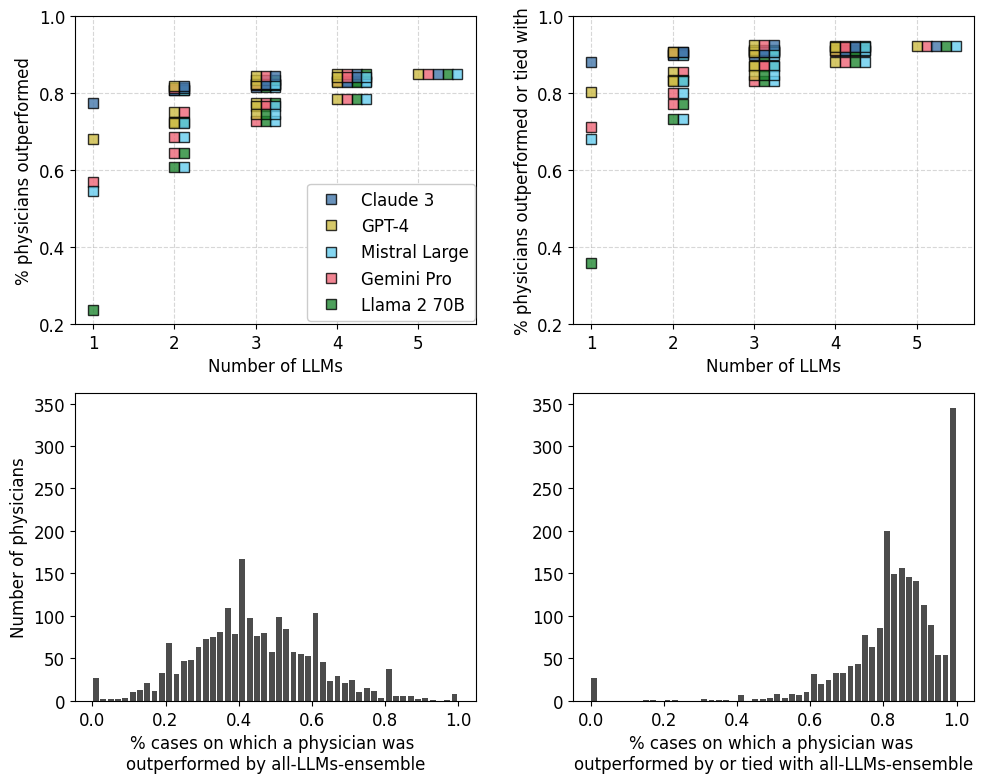

In [10]:
# Define the key for the combination of all LLMs
all_llm_key = 'OpenAI_gpt-4-1106-preview|GoogleAI_gemini-1.0-pro|AnthropicAI_claude-3-opus-20240229|MetaAI_llama-2-70b-f|MistralAI_mistral-large-latest'

metric = 'mrr'
metric2 = 'outperform'
metric3 = 'tie'
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey='row')

# Plot settings for the top left subplot
plt.sca(axes[0][0])
metric_label_dict = {"top5": "Top 5", "top3": "Top 3", "top1": "Top 1", "mrr": "MRR"}

# Convert summary_stats_df_means to a dictionary for easier access
mean_dict = summary_stats_df_means[summary_stats_df_means['metric'] == metric].set_index('combo').T.to_dict()

# Plotting data points for each combination of LLMs
for k, v in mean_dict.items():
    jitter = 0
    klist = k.split('|')
    for i, item in enumerate(klist):
        if len(klist) == 1:
            plt.plot(jitter + len(klist) + 0.12 * i, v[metric2], ms="7", marker='s', linestyle='None', color=colors[item],
                     label=labels[item], markeredgecolor='black', alpha=0.8)
        else:
            plt.plot(jitter + len(klist) + 0.12 * i, v[metric2], ms="7", marker='s', linestyle='None',
                     color=colors[item], markeredgecolor='black', alpha=0.8)

plt.xticks([1, 2, 3, 4, 5])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel('Number of LLMs')
plt.ylabel('% physicians outperformed')
plt.ylim(0.2, 1.0)
plt.grid(axis='y', ls='--', alpha=0.5)
plt.grid(axis='x', ls='--', alpha=0.5)

# Legend handling
handles, legend_labels = axes[0][0].get_legend_handles_labels()
order = [0, 4, 3, 1, 2]
handles = [handles[idx] for idx in order]
legend_labels = [legend_labels[idx] for idx in order]
plt.legend(handles, legend_labels, loc=(0.58, 0.01), framealpha=1.0)

# Plot settings for the top right subplot
plt.sca(axes[0][1])
axes[0][1].tick_params(axis='y', labelleft=True)

# Plotting data points for each combination of LLMs (including ties)
for k, v in mean_dict.items():
    jitter = 0
    klist = k.split('|')
    for i, item in enumerate(klist):
        if len(klist) == 1:
            plt.plot(jitter + len(klist) + 0.12 * i, v[metric2] + v[metric3], ms="7", marker='s', linestyle='None', color=colors[item],
                     label=labels[item], markeredgecolor='black', alpha=0.8)
        else:
            plt.plot(jitter + len(klist) + 0.12 * i, v[metric2] + v[metric3], ms="7", marker='s', linestyle='None',
                     color=colors[item], markeredgecolor='black', alpha=0.8)

plt.xticks([1, 2, 3, 4, 5])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel('Number of LLMs')
plt.ylabel('% physicians outperformed or tied with')
plt.grid(axis='y', ls='--', alpha=0.5)
plt.grid(axis='x', ls='--', alpha=0.5)

# Plot settings for the bottom left subplot
plt.sca(axes[1][0])
all_combo = 'OpenAI_gpt-4-1106-preview|GoogleAI_gemini-1.0-pro|AnthropicAI_claude-3-opus-20240229|MetaAI_llama-2-70b-f|MistralAI_mistral-large-latest'
f = plt.hist(performance_results_df[performance_results_df['combo'] == all_combo].groupby('solver_id')['outperform_ratio'].mean(), bins=50, color='black', rwidth=0.8, alpha=0.7)
plt.xlabel('% cases on which a physician was \noutperformed by all-LLMs-ensemble')
plt.ylabel('Number of physicians')

# Plot settings for the bottom right subplot
plt.sca(axes[1][1])
f = plt.hist(performance_results_df[performance_results_df['combo'] == all_combo].groupby('solver_id')['outperform_or_tie_ratio'].mean(), bins=50, color='black', rwidth=0.8, alpha=0.7)
plt.xlabel('% cases on which a physician was \noutperformed by or tied with all-LLMs-ensemble')
axes[1][1].tick_params(axis='y', labelleft=True)

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig('./plots_nature/percentage_humans_outperformed.png', bbox_inches='tight', format="png", dpi=300)
plt.show()


### LLM ensembles for different specialties

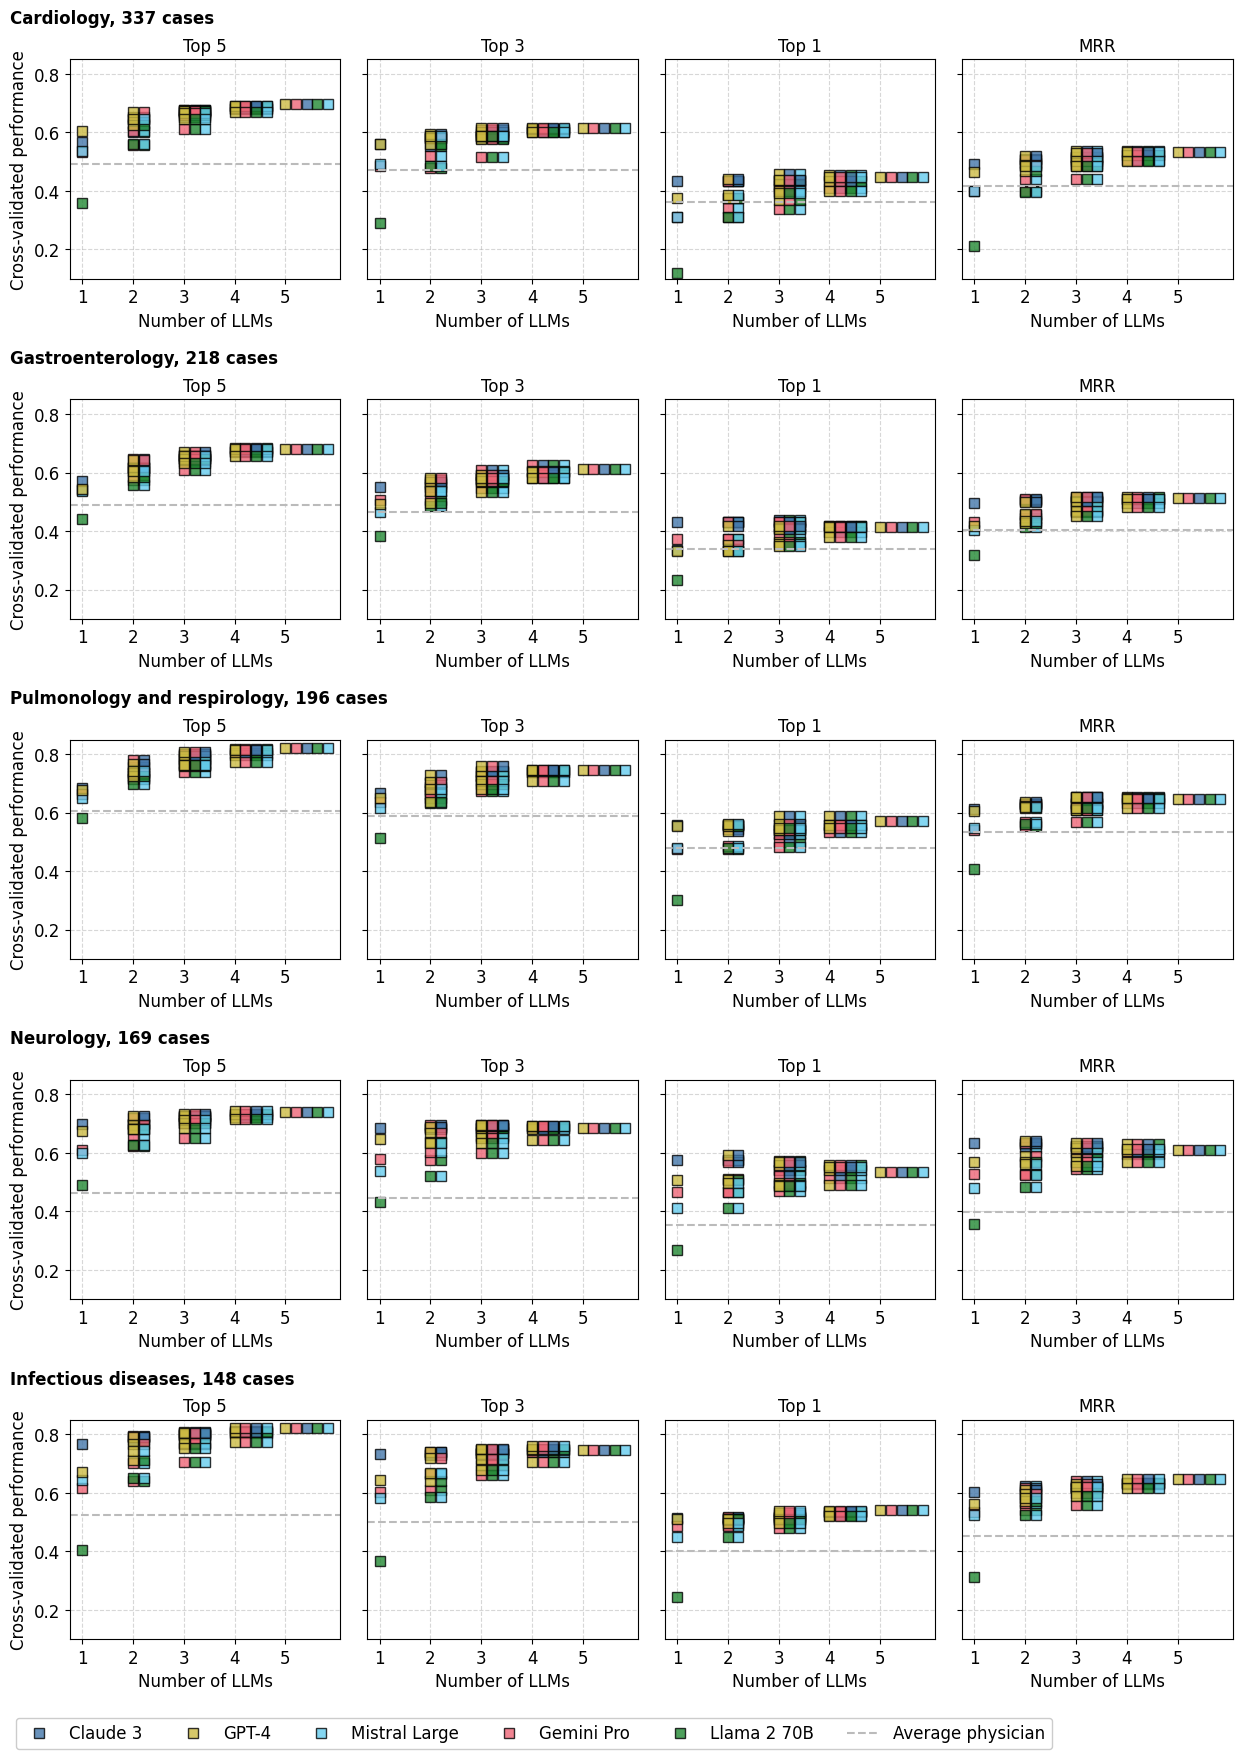

In [11]:
# Count the number of unique cases per specialty
specialties_count_onlyfirstlabel = Counter([case_specialties[cid][1][0] for cid in machine_collective_df['pc_id'].unique()])

# Create subplots with shared y-axis
fig, axes = plt.subplots(5, 4, figsize=(15, 20), sharey=True)
plt.subplots_adjust(top=0.9, hspace=0.55, wspace=0.1)
metric_label_dict = {"top5": "Top 5", "top3": "Top 3", "top1": "Top 1", "mrr": "MRR"}
row_titles = []

# Loop through the top 5 specialties with the most cases
for g, (specialty, ncases) in enumerate(specialties_count_onlyfirstlabel.most_common()[:5]):
    row_titles.append(f'{specialty}, {ncases} cases')

    for j, metric in enumerate(["top5", "top3", "top1", "mrr"]):
        ax = axes[g, j]
        plt.sca(ax)
        mean_dict = machine_collective_means_specialty[
            (machine_collective_means_specialty['metric'] == metric) &
            (machine_collective_means_specialty['case_specialty'] == specialty)
        ].set_index('combo').T.to_dict()

        # Plot data points for each combination of LLMs
        for k, v in mean_dict.items():
            jitter = 0
            klist = k.split('|')
            for i, item in enumerate(klist):
                if len(klist) == 1:
                    plt.plot(jitter + len(klist) + 0.21 * i, v[metric], ms="7", marker='s', linestyle='None', color=colors[item],
                             label=labels[item], markeredgecolor='black', alpha=0.8)
                else:
                    plt.plot(jitter + len(klist) + 0.21 * i, v[metric], ms="7", marker='s', linestyle='None',
                             color=colors[item], markeredgecolor='black', alpha=0.8)

        plt.title(metric_label_dict[metric], fontsize=12)
        plt.xticks([1, 2, 3, 4, 5])
        plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        plt.xlabel('Number of LLMs')
        plt.grid(axis='y', ls='--', alpha=0.5)
        plt.grid(axis='x', ls='--', alpha=0.5)

        # Plot the professional specialty line
        plt.axhline(y=means_professional_specialty.loc[specialty][metric], color=colors['Professional'], linestyle='--', label=labels['Professional'])

        if j == 0:
            plt.ylabel('Cross-validated performance')
        if j == 0 and g == 5:
            lhandles, llabels = ax.get_legend_handles_labels()
            ax.legend(lhandles[:5], llabels[:5], loc=(0, -0.4), ncol=5)

# Set y-axis limit for all plots
plt.ylim(0.1, 0.85)

# Add row titles to the figure
for i, ax in enumerate(axes):
    fig.text(0.085, ax[0].get_position().y1 + 0.016, row_titles[i], va='bottom', ha='left', fontsize=12, fontweight='bold', transform=fig.transFigure)

# Add legend to the plot
handles, legend_labels = axes[0][0].get_legend_handles_labels()
order = [0, 4, 3, 1, 2, 5]
handles = [handles[idx] for idx in order]
legend_labels = [legend_labels[idx] for idx in order]
plt.legend(handles, legend_labels, loc=(-3.5, -0.5), ncol=7, framealpha=1.0)

# Save and show the plot
plt.savefig('./plots_nature/specialties_machine_combos.png', bbox_inches='tight', format="png", dpi=300)
plt.show()


# Hybrid Human LLM ensembles

In [13]:

# Calculate hybrid collective diagnoses ( with weights applied )

# Define constants
NUM_SOLVES_TO_USE_PER_CASE = 5
COLLECTIVE_SOLVERS_TO_TEST = list(range(0, NUM_SOLVES_TO_USE_PER_CASE + 1))

# Define possible machine combinations (hybrid collectives)
possible_mcombos = [
    [], # Just human solvers
    ['OpenAI_gpt-4-1106-preview'],
    ['GoogleAI_gemini-1.0-pro'],
    ['AnthropicAI_claude-3-opus-20240229'],
    ['MetaAI_llama-2-70b-f'],
    ['MistralAI_mistral-large-latest'],
    ['OpenAI_gpt-4-1106-preview',
     'GoogleAI_gemini-1.0-pro',
     'AnthropicAI_claude-3-opus-20240229',
     'MetaAI_llama-2-70b-f',
     'MistralAI_mistral-large-latest']
]

# Set random seeds for reproducibility
random.seed(12345)
np.random.seed(12345)
folds = 5

# Define model keys
model_keys = [
    'OpenAI_gpt-4-1106-preview',
    'GoogleAI_gemini-1.0-pro',
    'AnthropicAI_claude-3-opus-20240229',
    'MetaAI_llama-2-70b-f',
    'MistralAI_mistral-large-latest'
]

collective_solves_dfs = []
case_ids = list(selectedcases_id_to_solves_profs_min5.keys())
# Shuffle the case IDs
random.shuffle(case_ids)
ntrain = int(np.floor(len(case_ids) / folds))

# Loop through folds for cross-validation
for j in range(5):
    train_cids = case_ids[j * ntrain : j * ntrain + ntrain]
    test_cids = case_ids[:j * ntrain] + case_ids[j * ntrain + ntrain:]
    metrics = ['top5', 'top3', 'top1', 'mrr']

    # Calculate performance on the training set to pick the best performing prompt
    mkey_to_mweight = {'top5': defaultdict(dict), 'top3': defaultdict(dict), 'top1': defaultdict(dict), 'mrr': defaultdict(dict)}

    for exp_setting in exp_settings:
        for model_key in model_keys:
            correct5, correct3, correct1, mrr_score, total = 0, 0, 0, 0, 0

            for case_id in train_cids:
                machine_solve = case_id_to_mkey_to_msolve[case_id][model_key][exp_setting]
                if machine_solve.match_pos is not None:
                    match_pos = machine_solve.match_pos if machine_solve.match_pos != -1 else np.inf
                    mrr_score += 1 / (match_pos + 1)
                if 0 <= machine_solve.match_pos < 1:
                    correct5 += 1
                    correct3 += 1
                    correct1 += 1
                elif 0 <= machine_solve.match_pos < 3:
                    correct5 += 1
                    correct3 += 1
                elif 0 <= machine_solve.match_pos < 5:
                    correct5 += 1
                total += 1

                mkey_to_mweight['top5'][model_key][exp_setting] = correct5 / total
                mkey_to_mweight['top3'][model_key][exp_setting] = correct3 / total
                mkey_to_mweight['top1'][model_key][exp_setting] = correct1 / total
                mkey_to_mweight['mrr'][model_key][exp_setting] = mrr_score / total

    m_exp_setting = defaultdict(dict)
    mkey_to_score = defaultdict(dict)

    # Determine the best performing prompt for each metric
    for metric in mkey_to_mweight.keys():
        for k, v in mkey_to_mweight[metric].items():
            best_key, best_val = '', 0
            for prompt, acc in v.items():
                if acc > best_val:
                    best_key, best_val = prompt, acc
            m_exp_setting[metric][k] = best_key
            mkey_to_score[metric][k] = best_val

    # Process hybrid combinations
    for metric in ['top5', 'top3', 'top1', 'mrr']:
        for m_list in possible_mcombos:
            print(f"*********************************************")
            print(f"Processing hybrid combo: {m_list}...")
            print(f"*********************************************")
            for num_solvers in COLLECTIVE_SOLVERS_TO_TEST:
                combo_key = " + ".join(m_list) + f" + {num_solvers} human solvers"
                if num_solvers == 0 and len(m_list) == 0:
                    continue
                elif num_solvers == 0: # no human, llm ensemble only
                    # Calculate weights on training cases for llm ensemble only
                    mkey_to_weight = calculate_weights_wmve(m_list, m_exp_setting[metric], train_cids, case_id_to_mkey_to_msolve, metric)

                    machine_solves_df = process_machine_combo(
                        m_list,
                        m_exp_setting[metric],
                        m_case_ids_culled=test_cids,
                        case_id_to_mkey_to_msolve=case_id_to_mkey_to_msolve,
                        mkey_to_weight=mkey_to_weight,
                        case_id_to_case=case_id_to_case,
                        pos_weight_fn=_one_over_position
                    )

                    machine_solves_df['fold'] = j
                    machine_solves_df['metric'] = metric
                    machine_solves_df['combo_key'] = combo_key
                    collective_solves_dfs.append(machine_solves_df)

                else: #hybrid humans + llm
                    # Calculate weights on training cases for hybrid solves
                    wmve_weights = calculate_weights_wmve_hybrid(
                        m_list,
                        m_exp_setting[metric],
                        train_cids,
                        case_id_to_mkey_to_msolve,
                        metric,
                        selectedcases_id_to_solves_profs_min5,
                        num_solvers,
                        sample_n_combis=100,
                        max_guesses_allowed=1000
                    )

                    results = process_hybrid_solves(
                        m_list,
                        m_exp_setting[metric],
                        num_solvers,
                        test_cids,
                        wmve_weights,
                        case_id_to_mkey_to_msolve,
                        selectedcases_id_to_solves_profs_min5,
                        case_id_to_case,
                        sample_n_combis=100,
                    )
                    results['combo_key'] = combo_key
                    results['fold'] = j
                    results['metric'] = metric
                    collective_solves_dfs.append(results)

# Combine all results into a single DataFrame
hybrid_collective_df = pd.concat(collective_solves_dfs)
hybrid_collective_df['top1'] = hybrid_collective_df['match_pos'] == 0
hybrid_collective_df['top3'] = (hybrid_collective_df['match_pos'] >= 0) & (hybrid_collective_df['match_pos'] < 3)
hybrid_collective_df['top5'] = (hybrid_collective_df['match_pos'] >= 0) & (hybrid_collective_df['match_pos'] < 5)
hybrid_collective_df['mrr'] = np.where(
    (hybrid_collective_df['match_pos'] >= 0) & (hybrid_collective_df['match_pos'] < 5),
    1 / (hybrid_collective_df['match_pos'] + 1), 0
)

# Add specialty information
hybrid_collective_df['case_specialty'] = hybrid_collective_df['pc_id'].map(lambda x: case_specialties[x][1][0])
hybrid_collective_df_sample_means = hybrid_collective_df.groupby(['case_specialty', 'metric', 'combo_key', 'fold', 'pc_id'])[['top1', 'top3', 'top5', 'mrr']].mean()
hybrid_collective_means = hybrid_collective_df_sample_means.reset_index().groupby(['metric', 'combo_key'])[['top1', 'top3', 'top5', 'mrr']].mean()
hybrid_collective_means.reset_index(inplace=True)
hybrid_collective_specialty_means = hybrid_collective_df_sample_means.reset_index().groupby(['case_specialty', 'metric', 'combo_key'])[['top1', 'top3', 'top5', 'mrr']].mean()
hybrid_collective_specialty_means.reset_index(inplace=True)

# Filter and format the results 
hybrid_collective_means_filtered = []
for metric in ['top1', 'top3', 'top5', 'mrr']:
    hybrid_collective_means_filtered.append(pd.DataFrame(hybrid_collective_means[hybrid_collective_means['metric'] == metric].set_index('combo_key')[metric]))
hybrid_collective_means_filtered = pd.concat(hybrid_collective_means_filtered, axis=1)
hybrid_collective_means_filtered = hybrid_collective_means_filtered.apply(lambda col: col.round(decimals=3))
hybrid_collective_means_filtered.index = hybrid_collective_means_filtered.index.map(lambda x: ' + '.join([labels[key.strip()] if key.strip() in labels else key for key in x.split('+')]))
hybrid_collective_means_filtered.reset_index()


*********************************************
Processing hybrid combo: []...
*********************************************
*********************************************
Processing hybrid combo: ['OpenAI_gpt-4-1106-preview']...
*********************************************
Processing combo: ['OpenAI_gpt-4-1106-preview']...
*********************************************
Processing hybrid combo: ['GoogleAI_gemini-1.0-pro']...
*********************************************
Processing combo: ['GoogleAI_gemini-1.0-pro']...
*********************************************
Processing hybrid combo: ['AnthropicAI_claude-3-opus-20240229']...
*********************************************
Processing combo: ['AnthropicAI_claude-3-opus-20240229']...
*********************************************
Processing hybrid combo: ['MetaAI_llama-2-70b-f']...
*********************************************
Processing combo: ['MetaAI_llama-2-70b-f']...
*********************************************
Processing hybrid combo

,combo_key,top1,top3,top5,mrr
0,+ individual physician,0.388,0.495,0.514,0.441
1,+ 2 human solvers,0.412,0.620,0.665,0.518
2,+ 3 human solvers,0.473,0.668,0.726,0.571
3,+ 4 human solvers,0.510,0.687,0.758,0.604
4,+ 5-physician ensemble,0.533,0.705,0.777,0.626
5,Claude 3 + 0 human solvers,0.499,0.631,0.661,0.563
6,Claude 3 + individual physician,0.500,0.672,0.724,0.590
7,Claude 3 + 2 human solvers,0.523,0.707,0.768,0.618
8,Claude 3 + 3 human solvers,0.541,0.725,0.788,0.638
9,Claude 3 + 4 human solvers,0.553,0.738,0.801,0.652


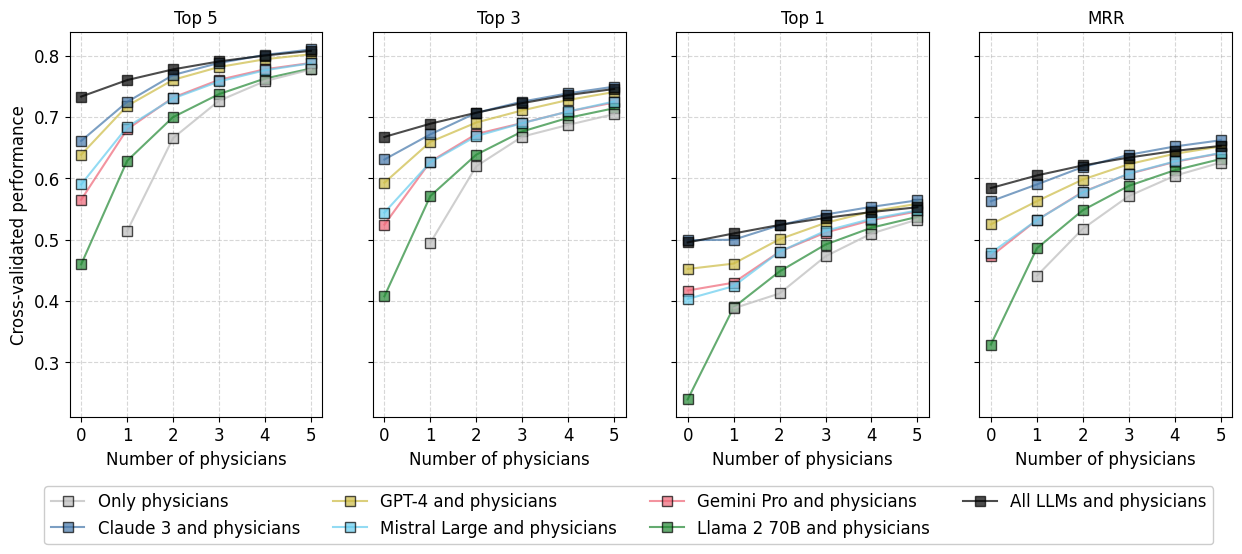

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
plt.subplots_adjust(hspace=0.55, wspace=0.2)


of_interest = [                
    'OpenAI_gpt-4-1106-preview',
    'GoogleAI_gemini-1.0-pro',
    'AnthropicAI_claude-3-opus-20240229',
    'MetaAI_llama-2-70b-f',
    'MistralAI_mistral-large-latest',
    '',     
    'OpenAI_gpt-4-1106-preview + GoogleAI_gemini-1.0-pro + AnthropicAI_claude-3-opus-20240229 + MetaAI_llama-2-70b-f + MistralAI_mistral-large-latest', 
]
       
colors_of_interest = [
    colors['OpenAI_gpt-4-1106-preview'],
    colors['GoogleAI_gemini-1.0-pro'],
    colors['AnthropicAI_claude-3-opus-20240229'],
    colors['MetaAI_llama-2-70b-f'], 
    colors['MistralAI_mistral-large-latest'],
    colors['Professional'],
    'black',
]
metric_label_dict = {"top5": "Top 5", "top3": "Top 3", "top1": "Top 1", "mrr": "MRR"}

for j,metric in enumerate(["top5", "top3", "top1", "mrr"]):
    plt.sca(axes[j])  
    mean_dict = hybrid_collective_means[(hybrid_collective_means['metric']==metric)].set_index('combo_key').T.to_dict()
    for i,m_list in enumerate(of_interest):
        if m_list != '':
            x = COLLECTIVE_SOLVERS_TO_TEST
            y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST]
            if m_list == 'OpenAI_gpt-4-1106-preview + GoogleAI_gemini-1.0-pro + AnthropicAI_claude-3-opus-20240229 + MetaAI_llama-2-70b-f + MistralAI_mistral-large-latest':
                plt.plot(x,y, ms="7", marker = 's',linestyle='-', color = colors_of_interest[i], markeredgecolor='black', alpha=0.7,
                         label = 'All LLMs and physicians')
            else:
                plt.plot(x,y, ms="7", marker = 's',linestyle='-', color = colors_of_interest[i], markeredgecolor='black', alpha=0.7, label = labels[m_list] +' and physicians')
        else:
            x = COLLECTIVE_SOLVERS_TO_TEST[1:]
            y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST[1:]]
            plt.plot(x,y, ms="7", marker = 's',linestyle='-', color = colors_of_interest[i], markeredgecolor='black', alpha=0.7, label = 'Only physicians')
    
    
    plt.xticks([0,1,2,3,4,5])
    plt.grid(axis='y', ls='--', alpha=0.5)
    plt.grid(axis='x', ls='--', alpha=0.5)
    plt.xlabel('Number of physicians')
    plt.title(metric_label_dict[metric], fontsize=12)
    if j==0:
        plt.ylabel('Cross-validated performance')
        
handles, legend_labels = axes[1].get_legend_handles_labels()
order = [5,2,0,4,1,3,6]
handles = [handles[idx] for idx in order]
legend_labels = [legend_labels[idx] for idx in order]
plt.legend(handles, legend_labels, framealpha=1.0,  ncol=4, loc= (-3.7,-0.33))


plt.savefig(f'./plots_nature/acc_metricgrid_weightedLLMsHumans.png', bbox_inches='tight', format="png", dpi=300)

plt.show()


#### Hybrid ensembles for different specialties

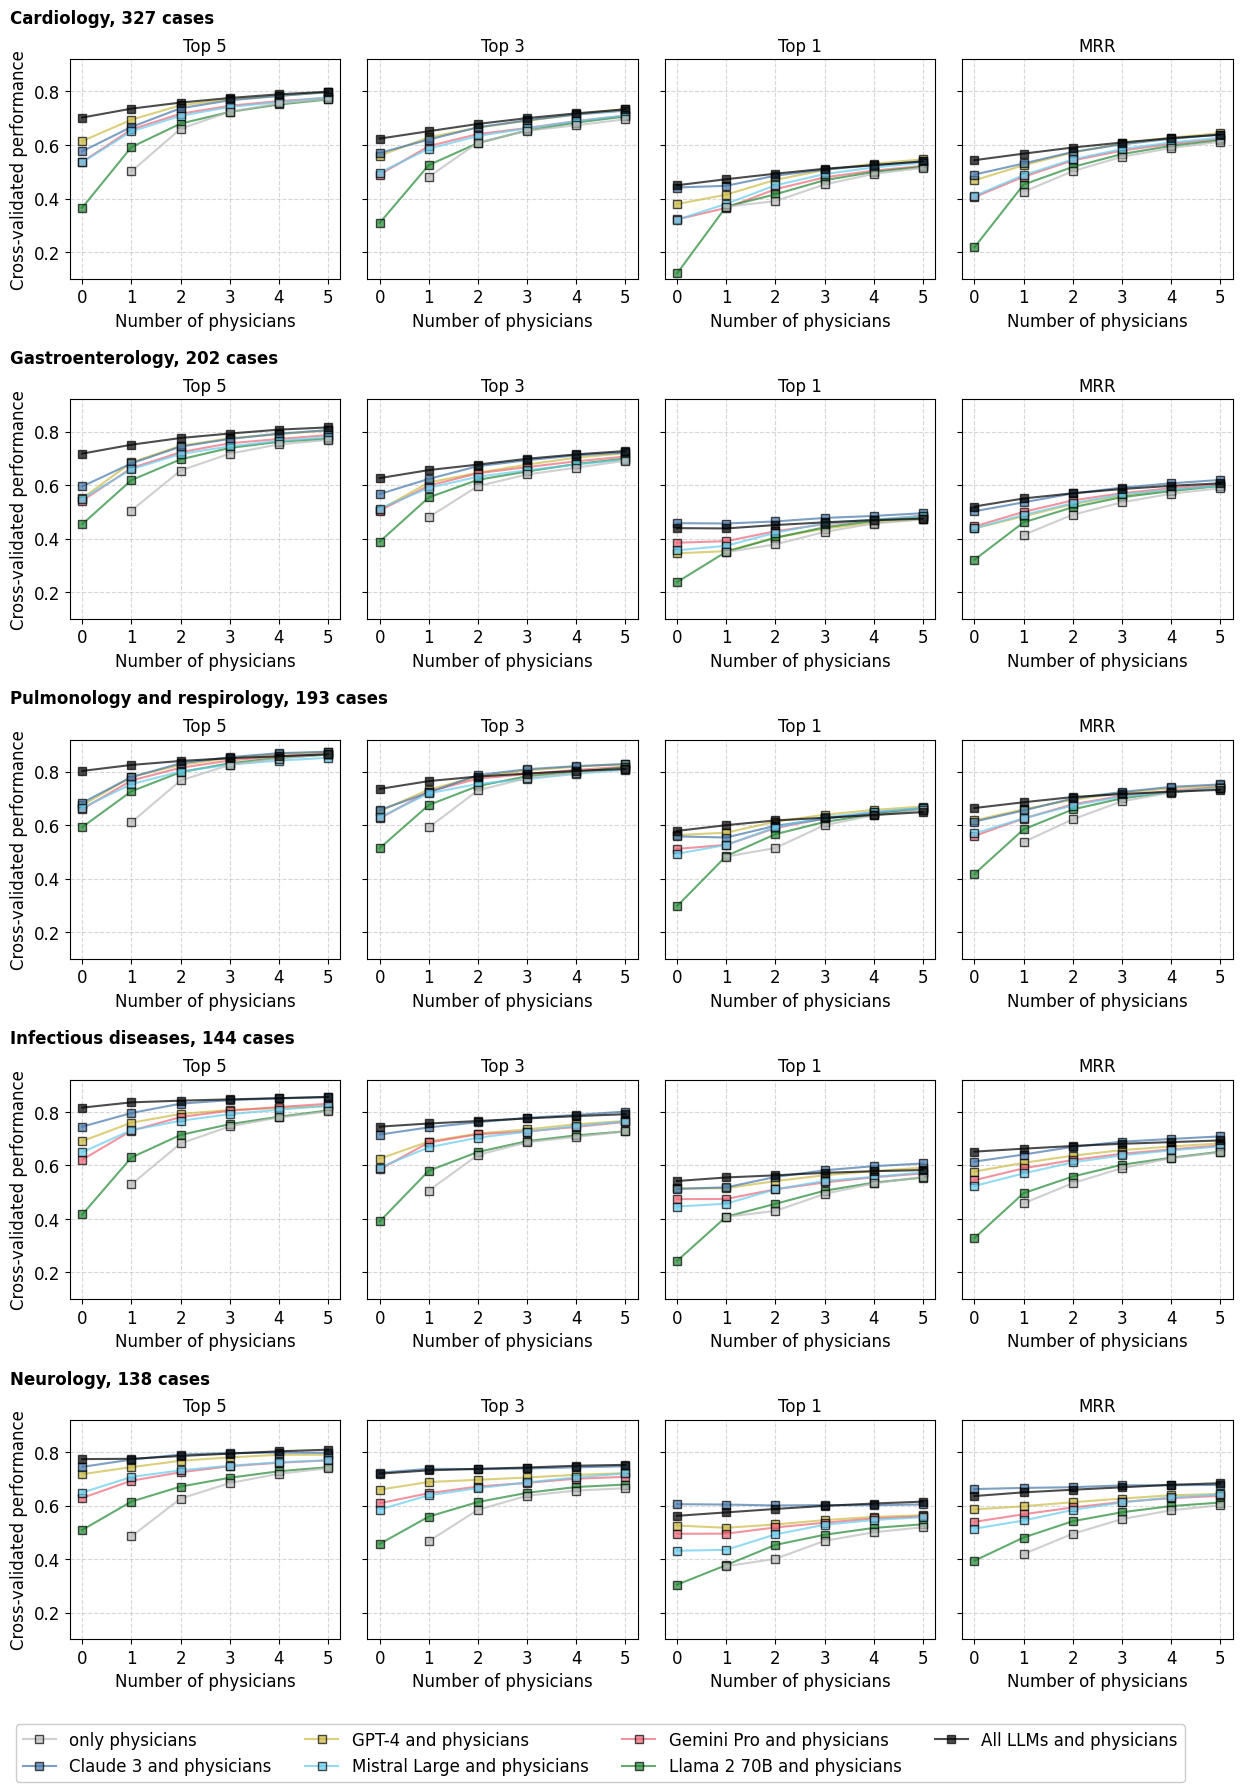

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(15, 20), sharey=True)
plt.subplots_adjust(top=0.9, hspace=0.55, wspace=0.1)
metric_label_dict = {"top5": "Top 5", "top3": "Top 3", "top1": "Top 1", "mrr": "MRR"}
row_titles = []

specialties_count_onlyfirstlabel = Counter(
    [case_specialties[cid][1][0] for cid in hybrid_collective_df['pc_id'].unique()])
for g,(specialty,ncases) in enumerate(specialties_count_onlyfirstlabel.most_common()[:5]):
    row_titles.append(f'{specialty}, {ncases} cases')
    for j,metric in enumerate(["top5", "top3", "top1", "mrr"]):
        ax = axes[g,j]
        plt.sca(ax)
        mean_dict = hybrid_collective_specialty_means[(hybrid_collective_specialty_means['metric']==metric)
                                                      & (hybrid_collective_specialty_means['case_specialty']==specialty)].set_index('combo_key').T.to_dict()
        for i,m_list in enumerate(of_interest):
            if m_list != '':
                x = COLLECTIVE_SOLVERS_TO_TEST
                y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST]
                if m_list == 'OpenAI_gpt-4-1106-preview + GoogleAI_gemini-1.0-pro + AnthropicAI_claude-3-opus-20240229 + MetaAI_llama-2-70b-f + MistralAI_mistral-large-latest':
                    plt.plot(x,y, ms="6", marker = 's',linestyle='-', color = colors_of_interest[i], markeredgecolor='black', alpha=0.7,
                             label = 'All LLMs and physicians')
                else:
                    plt.plot(x,y, ms="6", marker = 's',linestyle='-', color = colors_of_interest[i], markeredgecolor='black', alpha=0.7, label = labels[m_list] +' and physicians')
            else:
                x = COLLECTIVE_SOLVERS_TO_TEST[1:]
                y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST[1:]]
                plt.plot(x,y, ms="6", marker = 's',linestyle='-', color = colors_of_interest[i], markeredgecolor='black', alpha=0.7, label = 'only physicians')

        plt.title(metric_label_dict[metric], fontsize=12)
        plt.xticks([0,1,2,3,4,5])
        plt.yticks([0.2, 0.4, 0.6,0.8, 1.0])
        plt.xlabel('Number of physicians')

        plt.grid(axis='y', ls='--', alpha=0.5)
        plt.grid(axis='x', ls='--', alpha=0.5)

        if j==0:
            plt.ylabel('Cross-validated performance')
plt.ylim(0.1,0.92)

for i, ax in enumerate(axes):
    fig.text(0.085, ax[0].get_position().y1 + 0.016, row_titles[i], va='bottom', ha='left', fontsize=12, fontweight='bold', transform=fig.transFigure)

    
handles, legend_labels = axes[0][0].get_legend_handles_labels()
order = [5,2,0,4,1,3,6]
handles = [handles[idx] for idx in order]
legend_labels = [legend_labels[idx] for idx in order]
plt.legend(handles, legend_labels, framealpha=1.0,  ncol=4, loc= (-3.5,-0.65),)
plt.savefig(f'./plots_nature/specialties_machine_hybrid_combos.png', bbox_inches='tight', format="png", dpi=300)

plt.show()

## Effect of weighting 

In [ ]:
# Hybrid ensembles without weights

# Define constants
NUM_SOLVES_TO_USE_PER_CASE = 5
COLLECTIVE_SOLVERS_TO_TEST = list(range(0, NUM_SOLVES_TO_USE_PER_CASE + 1))

# Define possible machine combinations
possible_mcombos = [
    [], # just humans
    ['OpenAI_gpt-4-1106-preview'],
    ['GoogleAI_gemini-1.0-pro'],
    ['AnthropicAI_claude-3-opus-20240229'],
    ['MetaAI_llama-2-70b-f'],
    ['MistralAI_mistral-large-latest'],
    ['OpenAI_gpt-4-1106-preview',
     'GoogleAI_gemini-1.0-pro',
     'AnthropicAI_claude-3-opus-20240229',
     'MetaAI_llama-2-70b-f',
     'MistralAI_mistral-large-latest']
]

# Set seeds for reproducibility
random.seed(12345)
np.random.seed(12345)
folds = 5

# Define model keys
model_keys = [
    'OpenAI_gpt-4-1106-preview',
    'GoogleAI_gemini-1.0-pro',
    'AnthropicAI_claude-3-opus-20240229',
    'MetaAI_llama-2-70b-f',
    'MistralAI_mistral-large-latest'
]

collective_solves_dfs_no_weights = []


case_ids = list(selectedcases_id_to_solves_profs_min5.keys())
random.shuffle(case_ids)
ntrain = int(np.floor(len(case_ids) / folds))

# Loop through folds for cross-validation
for j in range(5):
    print("j", j)
    train_cids = case_ids[j * ntrain:j * ntrain + ntrain]
    test_cids = case_ids[:j * ntrain] + case_ids[j * ntrain + ntrain:]

    metrics = ['top5', 'top3', 'top1', 'mrr']

    # Calculate performance on train_set to pick best performing prompt
    mkey_to_mweight = {metric: defaultdict(dict) for metric in metrics}

    # Loop through experimental settings and model keys
    for exp_setting in exp_settings:
        for model_key in model_keys:
            correct5, correct3, correct1, mrr_score, total = 0, 0, 0, 0, 0

            # Calculate scores for each case in the training set
            for case_id in train_cids:
                machine_solve = case_id_to_mkey_to_msolve[case_id][model_key][exp_setting]
                if machine_solve.match_pos is not None:
                    match_pos = machine_solve.match_pos
                    if match_pos == -1:
                        match_pos = np.inf
                    mrr_score += 1 / (match_pos + 1)
                    if 0 <= match_pos < 1:
                        correct5 += 1
                        correct3 += 1
                        correct1 += 1
                    elif 0 <= match_pos < 3:
                        correct5 += 1
                        correct3 += 1
                    elif 0 <= match_pos < 5:
                        correct5 += 1
                    total += 1

            # Store calculated scores
            mkey_to_mweight['top5'][model_key][exp_setting] = correct5 / total
            mkey_to_mweight['top3'][model_key][exp_setting] = correct3 / total
            mkey_to_mweight['top1'][model_key][exp_setting] = correct1 / total
            mkey_to_mweight['mrr'][model_key][exp_setting] = mrr_score / total

    m_exp_setting = defaultdict(dict)
    mkey_to_score = defaultdict(dict)

    # Determine the best performing prompt for each metric
    for metric in mkey_to_mweight.keys():
        for k, v in mkey_to_mweight[metric].items():
            best_key, best_val = '', 0
            for prompt, acc in v.items():
                if acc > best_val:
                    best_key = prompt
                    best_val = acc
            m_exp_setting[metric][k] = best_key
            mkey_to_score[metric][k] = best_val

    # Loop through metrics and machine combinations to process hybrid solves
    for metric in ['top5', 'top3', 'top1', 'mrr']:
        for m_list in possible_mcombos:
            print(f"*********************************************")
            print(f"Processing hybrid combo: {m_list}...")
            print(f"*********************************************")

            for num_solvers in COLLECTIVE_SOLVERS_TO_TEST:
                combo_key = " + ".join(m_list) + f" + {num_solvers} human solvers"
                if num_solvers == 0 and len(m_list) == 0:
                    continue
                elif num_solvers == 0:
                    # Process machine-only solves
                    machine_solves_df = process_machine_combo(
                        m_list,
                        m_exp_setting[metric],
                        m_case_ids_culled=test_cids,
                        case_id_to_mkey_to_msolve=case_id_to_mkey_to_msolve,
                        mkey_to_weight={},
                        case_id_to_case=case_id_to_case,
                        pos_weight_fn=_one_over_position,
                        use_weights=False
                    )
                    machine_solves_df['fold'] = j
                    machine_solves_df['metric'] = metric
                    machine_solves_df['combo_key'] = combo_key
                    collective_solves_dfs_no_weights.append(machine_solves_df)
                else:
                    # Process hybrid solves (machine + human)
                    results = process_hybrid_solves(
                        m_list,
                        m_exp_setting[metric],
                        num_solvers,
                        test_cids,
                        wmve_weights,
                        case_id_to_mkey_to_msolve,
                        selectedcases_id_to_solves_profs_min5,
                        case_id_to_case,
                        sample_n_combis=100,
                        weights=False
                    )
                    results['combo_key'] = combo_key
                    results['fold'] = j
                    results['metric'] = metric
                    collective_solves_dfs_no_weights.append(results)


j 0
*********************************************
Processing hybrid combo: []...
*********************************************
*********************************************
Processing hybrid combo: ['OpenAI_gpt-4-1106-preview']...
*********************************************
Processing combo: ['OpenAI_gpt-4-1106-preview']...
*********************************************
Processing hybrid combo: ['GoogleAI_gemini-1.0-pro']...
*********************************************
Processing combo: ['GoogleAI_gemini-1.0-pro']...
*********************************************
Processing hybrid combo: ['AnthropicAI_claude-3-opus-20240229']...
*********************************************
Processing combo: ['AnthropicAI_claude-3-opus-20240229']...
*********************************************
Processing hybrid combo: ['MetaAI_llama-2-70b-f']...
*********************************************
Processing combo: ['MetaAI_llama-2-70b-f']...
*********************************************
Processing hybrid c

In [ ]:
# Concatenate all the DataFrames into one
hybrid_collective_df_no_weights = pd.concat(collective_solves_dfs_no_weights)

# Calculate metrics for each collective solve
hybrid_collective_df_no_weights['top1'] = hybrid_collective_df_no_weights['match_pos'] == 0
hybrid_collective_df_no_weights['top3'] = (hybrid_collective_df_no_weights['match_pos'] >= 0) & (hybrid_collective_df_no_weights['match_pos'] < 3)
hybrid_collective_df_no_weights['top5'] = (hybrid_collective_df_no_weights['match_pos'] >= 0) & (hybrid_collective_df_no_weights['match_pos'] < 5)
hybrid_collective_df_no_weights['mrr'] = np.where(
    (hybrid_collective_df_no_weights['match_pos'] >= 0) & (hybrid_collective_df_no_weights['match_pos'] < 5),
    1 / (hybrid_collective_df_no_weights['match_pos'] + 1), 0
)

# Map each case to its specialty
hybrid_collective_df_no_weights['case_specialty'] = hybrid_collective_df_no_weights['pc_id'].map(lambda x: case_specialties[x][1][0])

# Group by case specialty, metric, combo key, fold, and case ID, then calculate mean values for each group
hybrid_collective_df_sample_means_no_weights = hybrid_collective_df_no_weights.groupby(
    ['case_specialty', 'metric', 'combo_key', 'fold', 'pc_id']
)[['top1', 'top3', 'top5', 'mrr']].mean()

# Reset index and group by metric and combo key to calculate mean values across folds and cases
hybrid_collective_means_no_weights = hybrid_collective_df_sample_means_no_weights.reset_index().groupby(
    ['metric', 'combo_key']
)[['top1', 'top3', 'top5', 'mrr']].mean()
hybrid_collective_means_no_weights.reset_index(inplace=True)

# Group by case specialty, metric, and combo key to calculate mean values across folds and cases
hybrid_collective_specialty_means_no_weights = hybrid_collective_df_sample_means_no_weights.reset_index().groupby(
    ['case_specialty', 'metric', 'combo_key']
)[['top1', 'top3', 'top5', 'mrr']].mean()
hybrid_collective_specialty_means_no_weights.reset_index(inplace=True)

# Calculate overall means by grouping by metric and combo key, then averaging across cases
hybrid_collective_means_no_weights = hybrid_collective_df_no_weights.groupby(
    ['metric', 'combo_key', 'pc_id']
)[['top1', 'top3', 'top5', 'mrr']].mean().reset_index().groupby(
    ['metric', 'combo_key']
)[['top1', 'top3', 'top5', 'mrr']].mean().reset_index()

# signed performance gain through weights
hybrid_collective_weight_difference = (hybrid_collective_means.set_index(['combo_key', 'metric']) - hybrid_collective_means_no_weights.set_index(['combo_key', 'metric'])).reset_index()

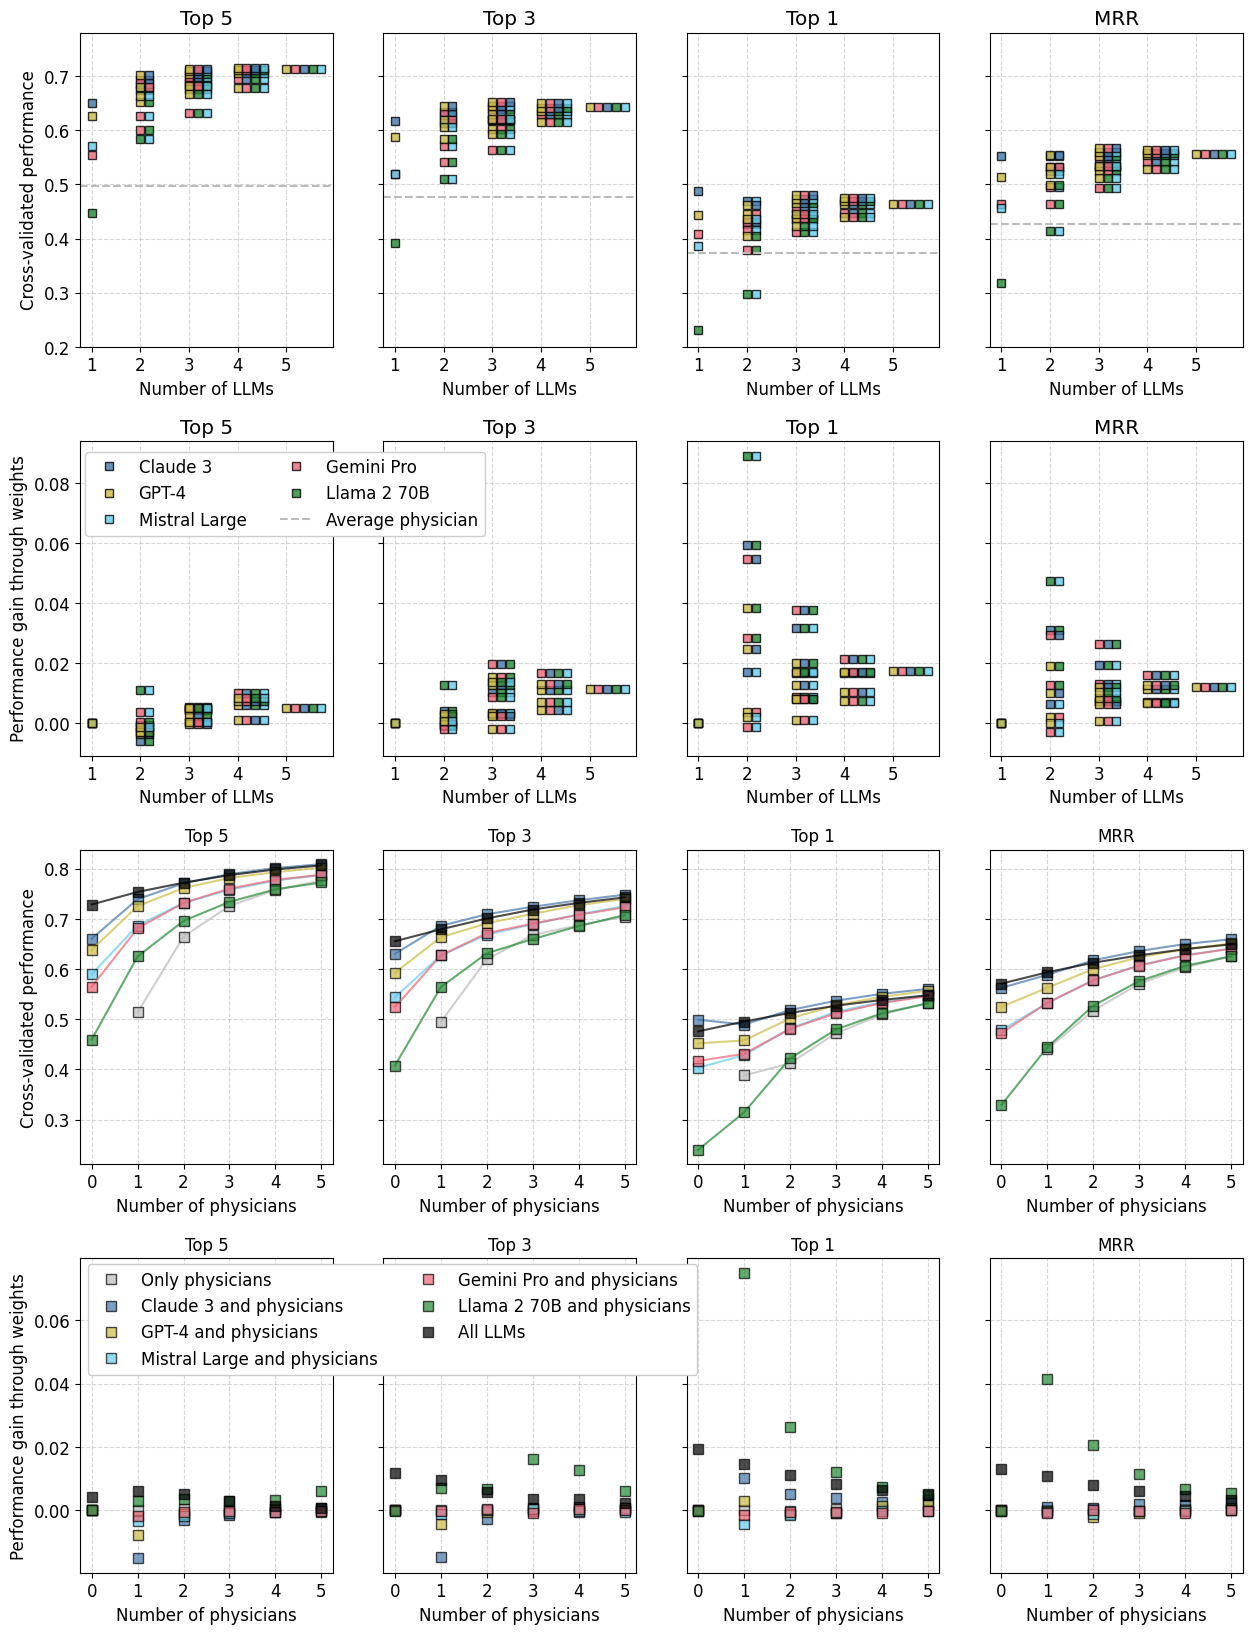

In [ ]:
# Create a 4x4 grid of subplots for plotting metrics
fig, axes = plt.subplots(4, 4, figsize=(15, 20), sharey="row")
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Dictionary for metric labels
metric_label_dict = {"top5": "Top 5", "top3": "Top 3", "top1": "Top 1", "mrr": "MRR"}

# First row: Plot machine collective means without weights
for j, metric in enumerate(["top5", "top3", "top1", "mrr"]):
    plt.sca(axes[0][j])
    mean_dict = machine_collective_means_no_weights[machine_collective_means_no_weights['metric'] == metric].set_index('combo').T.to_dict()
    for k, v in mean_dict.items():
        klist = k.split('|')
        for i, item in enumerate(klist):
            plt.plot(len(klist) + 0.18 * i, v[metric], ms="6", marker='s', linestyle='None', color=colors[item],
                     label=labels[item] if len(klist) == 1 else "", markeredgecolor='black', alpha=0.8)
    plt.xticks([1, 2, 3, 4, 5])
    plt.yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    plt.xlabel('Number of LLMs')
    if j == 0:
        plt.ylabel('Cross-validated performance')
    plt.grid(axis='y', ls='--', alpha=0.5)
    plt.grid(axis='x', ls='--', alpha=0.5)
    plt.title(metric_label_dict[metric])
    plt.axhline(y=means_professional[metric], color=colors['Professional'], linestyle='--', label=labels['Professional'])

plt.ylim(0.2, 0.78)

# Second row: Plot performance gain through weights
for j, metric in enumerate(["top5", "top3", "top1", "mrr"]):
    plt.sca(axes[1][j])
    mean_dict = machine_collective_weight_difference[machine_collective_weight_difference['metric'] == metric].set_index('combo').T.to_dict()
    for k, v in mean_dict.items():
        klist = k.split('|')
        for i, item in enumerate(klist):
            plt.plot(len(klist) + 0.18 * i, v[metric], ms="6", marker='s', linestyle='None', color=colors[item],
                     label=labels[item] if len(klist) == 1 else "", markeredgecolor='black', alpha=0.8)
    plt.xticks([1, 2, 3, 4, 5])
    plt.xlabel('Number of LLMs')
    plt.grid(axis='y', ls='--', alpha=0.5)
    plt.grid(axis='x', ls='--', alpha=0.5)
    plt.title(metric_label_dict[metric])
    if j == 1:
        handles, legend_labels = axes[0][1].get_legend_handles_labels()
        order = [0, 4, 3, 1, 2, 5]
        handles = [handles[idx] for idx in order]
        legend_labels = [legend_labels[idx] for idx in order]
        plt.legend(handles, legend_labels, loc=(-1.18, 0.7), framealpha=1.0, ncol=2)
    if j == 0:
        plt.ylabel('Performance gain through weights')

# List of combinations of interest
of_interest = [
    '',
    'AnthropicAI_claude-3-opus-20240229',
    'OpenAI_gpt-4-1106-preview',
    'MistralAI_mistral-large-latest',
    'GoogleAI_gemini-1.0-pro',
    'MetaAI_llama-2-70b-f',
    'OpenAI_gpt-4-1106-preview + GoogleAI_gemini-1.0-pro + AnthropicAI_claude-3-opus-20240229 + MetaAI_llama-2-70b-f + MistralAI_mistral-large-latest',
]

# Corresponding colors for the combinations of interest
colors_of_interest = [
    colors['Professional'],
    colors['AnthropicAI_claude-3-opus-20240229'],
    colors['OpenAI_gpt-4-1106-preview'],
    colors['MistralAI_mistral-large-latest'],
    colors['GoogleAI_gemini-1.0-pro'],
    colors['MetaAI_llama-2-70b-f'],
    'black',
]

# Third row: Plot hybrid collective means without weights
for j, metric in enumerate(["top5", "top3", "top1", "mrr"]):
    plt.sca(axes[2][j])
    mean_dict = hybrid_collective_means_no_weights[hybrid_collective_means_no_weights['metric'] == metric].set_index('combo_key').T.to_dict()
    for i, m_list in enumerate(of_interest):
        if m_list != '':
            x = COLLECTIVE_SOLVERS_TO_TEST
            y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST]
            if m_list == 'OpenAI_gpt-4-1106-preview + GoogleAI_gemini-1.0-pro + AnthropicAI_claude-3-opus-20240229 + MetaAI_llama-2-70b-f + MistralAI_mistral-large-latest':
                plt.plot(x, y, ms="7", marker='s', linestyle='-', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7,
                         label='All LLMs')
            else:
                plt.plot(x, y, ms="7", marker='s', linestyle='-', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7, label=labels[m_list] + ' and physicians')
        else:
            x = COLLECTIVE_SOLVERS_TO_TEST[1:]
            y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST[1:]]
            plt.plot(x, y, ms="7", marker='s', linestyle='-', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7, label='Only physicians')
    plt.grid(axis='y', ls='--', alpha=0.5)
    plt.grid(axis='x', ls='--', alpha=0.5)
    plt.xlabel('Number of physicians')
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.title(metric_label_dict[metric], fontsize=12)
    if j == 0:
        plt.ylabel('Cross-validated performance')

# Fourth row: Plot hybrid collective weight differences
for j, metric in enumerate(["top5", "top3", "top1", "mrr"]):
    plt.sca(axes[3][j])
    mean_dict = hybrid_collective_weight_difference[hybrid_collective_weight_difference['metric'] == metric].set_index('combo_key').T.to_dict()
    for i, m_list in enumerate(of_interest):
        if m_list != '':
            x = COLLECTIVE_SOLVERS_TO_TEST
            y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST]
            if m_list == 'OpenAI_gpt-4-1106-preview + GoogleAI_gemini-1.0-pro + AnthropicAI_claude-3-opus-20240229 + MetaAI_llama-2-70b-f + MistralAI_mistral-large-latest':
                plt.plot(x, y, ms="7", marker='s', linestyle='None', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7,
                         label='All LLMs')
            else:
                plt.plot(x, y, ms="7", marker='s', linestyle='None', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7, label=labels[m_list] + ' and physicians')
        else:
            x = COLLECTIVE_SOLVERS_TO_TEST[1:]
            y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST[1:]]
            plt.plot(x, y, ms="7", marker='s', linestyle='None', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7, label='Only physicians')
    plt.grid(axis='y', ls='--', alpha=0.5)
    plt.grid(axis='x', ls='--', alpha=0.5)
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.xlabel('Number of physicians')
    plt.title(metric_label_dict[metric], fontsize=12)
    if j == 0:
        plt.ylabel('Performance gain through weights')

# Add a legend to the plot
plt.legend(title_fontproperties={"weight": "bold"}, ncol=2, loc=(-3.57, 0.63), framealpha=1)

# Save the figure as a PNG file
#plt.savefig(f'./plots_nature/acc_metricgrid_weighted_vs_no_weights_panel.png', bbox_inches='tight', format="png", dpi=300)

# Show the plot
plt.show()


## Hybrid ensembles with medical students and LLMs

In [ ]:
# STUDENT SOLVERS

# Define constants
NUM_SOLVES_TO_USE_PER_CASE = 5
COLLECTIVE_SOLVERS_TO_TEST = list(range(0, NUM_SOLVES_TO_USE_PER_CASE + 1))

# Define possible machine combinations
possible_mcombos = [
    [], # Just human solvers
    ['OpenAI_gpt-4-1106-preview'],
    ['GoogleAI_gemini-1.0-pro'],
    ['AnthropicAI_claude-3-opus-20240229'],
    ['MetaAI_llama-2-70b-f'],
    ['MistralAI_mistral-large-latest'],
    ['OpenAI_gpt-4-1106-preview',
     'GoogleAI_gemini-1.0-pro',
     'AnthropicAI_claude-3-opus-20240229',
     'MetaAI_llama-2-70b-f',
     'MistralAI_mistral-large-latest']
]

# Set seeds for reproducibility
random.seed(12345)
np.random.seed(12345)
folds = 5

# Define model keys
model_keys = [
    'OpenAI_gpt-4-1106-preview',
    'GoogleAI_gemini-1.0-pro',
    'AnthropicAI_claude-3-opus-20240229',
    'MetaAI_llama-2-70b-f',
    'MistralAI_mistral-large-latest'
]

# List to store the results for student solves
collective_solves_dfs_students = []

# Main loop
for i in range(1):
    case_ids = list(selectedcases_id_to_solves_medstudents_min5.keys())
    random.shuffle(case_ids)
    ntrain = int(np.floor(len(case_ids) / folds))

    # Loop through folds for cross-validation
    for j in range(5):
        train_cids = case_ids[j * ntrain:j * ntrain + ntrain]
        test_cids = case_ids[:j * ntrain] + case_ids[j * ntrain + ntrain:]

        metrics = ['top5', 'top3', 'top1', 'mrr']

        # Calculate performance on train_set to pick the best performing prompt
        mkey_to_mweight = {metric: defaultdict(dict) for metric in metrics}

        # Loop through experimental settings and model keys
        for exp_setting in exp_settings:
            for model_key in model_keys:
                correct5, correct3, correct1, mrr_score, total = 0, 0, 0, 0, 0

                # Calculate scores for each case in the training set
                for case_id in train_cids:
                    machine_solve = case_id_to_mkey_to_msolve[case_id][model_key][exp_setting]
                    if machine_solve.match_pos is not None:
                        match_pos = machine_solve.match_pos
                        if match_pos == -1:
                            match_pos = np.inf
                        mrr_score += 1 / (match_pos + 1)
                        if 0 <= match_pos < 1:
                            correct5 += 1
                            correct3 += 1
                            correct1 += 1
                        elif 0 <= match_pos < 3:
                            correct5 += 1
                            correct3 += 1
                        elif 0 <= match_pos < 5:
                            correct5 += 1
                        total += 1

                    # Store calculated scores
                    mkey_to_mweight['top5'][model_key][exp_setting] = correct5 / total
                    mkey_to_mweight['top3'][model_key][exp_setting] = correct3 / total
                    mkey_to_mweight['top1'][model_key][exp_setting] = correct1 / total
                    mkey_to_mweight['mrr'][model_key][exp_setting] = mrr_score / total

        m_exp_setting = defaultdict(dict)
        mkey_to_score = defaultdict(dict)

        # Determine the best performing prompt for each metric
        for metric in mkey_to_mweight.keys():
            for k, v in mkey_to_mweight[metric].items():
                best_key, best_val = '', 0
                for prompt, acc in v.items():
                    if acc > best_val:
                        best_key = prompt
                        best_val = acc
                m_exp_setting[metric][k] = best_key
                mkey_to_score[metric][k] = best_val

        # Loop through metrics and machine combinations to process hybrid solves
        for metric in ['top5', 'top3', 'top1', 'mrr']:
            for m_list in possible_mcombos:
                print(f"*********************************************")
                print(f"Processing hybrid combo: {m_list}...")
                print(f"*********************************************")

                for num_solvers in COLLECTIVE_SOLVERS_TO_TEST:
                    combo_key = " + ".join(m_list) + f" + {num_solvers} human solvers"
                    if num_solvers == 0 and len(m_list) == 0:
                        continue
                    elif num_solvers == 0:
                        # Calculate weights on training cases
                        mkey_to_weight = calculate_weights_wmve(m_list, m_exp_setting[metric], train_cids, case_id_to_mkey_to_msolve, metric)
                    
                        # Process machine-only solves
                        machine_solves_df = process_machine_combo(
                            m_list,
                            m_exp_setting[metric],
                            m_case_ids_culled=test_cids,
                            case_id_to_mkey_to_msolve=case_id_to_mkey_to_msolve,
                            mkey_to_weight=mkey_to_weight,
                            case_id_to_case=case_id_to_case,
                            pos_weight_fn=_one_over_position
                        )

                        machine_solves_df['fold'] = j
                        machine_solves_df['metric'] = metric
                        machine_solves_df['combo_key'] = combo_key
                        collective_solves_dfs_students.append(machine_solves_df)
                    else:
                        # Calculate weights on training cases for hybrid solves
                        wmve_weights = calculate_weights_wmve_hybrid(
                            m_list,
                            m_exp_setting[metric],
                            train_cids,
                            case_id_to_mkey_to_msolve,
                            metric, 
                            selectedcases_id_to_solves_medstudents_min5, 
                            num_solvers,
                            sample_n_combis=100,
                            max_guesses_allowed=1000
                        )

                        # Process hybrid solves (machine + human)
                        results = process_hybrid_solves(
                            m_list,
                            m_exp_setting[metric],
                            num_solvers,
                            test_cids,
                            wmve_weights,
                            case_id_to_mkey_to_msolve,
                            selectedcases_id_to_solves_medstudents_min5,
                            case_id_to_case,
                            sample_n_combis=100
                        )
                        results['combo_key'] = combo_key
                        results['fold'] = j
                        results['metric'] = metric
                        collective_solves_dfs_students.append(results)

        print("DONE -------")


*********************************************
Processing hybrid combo: []...
*********************************************
*********************************************
Processing hybrid combo: ['OpenAI_gpt-4-1106-preview']...
*********************************************
Processing combo: ['OpenAI_gpt-4-1106-preview']...
*********************************************
Processing hybrid combo: ['GoogleAI_gemini-1.0-pro']...
*********************************************
Processing combo: ['GoogleAI_gemini-1.0-pro']...
*********************************************
Processing hybrid combo: ['AnthropicAI_claude-3-opus-20240229']...
*********************************************
Processing combo: ['AnthropicAI_claude-3-opus-20240229']...
*********************************************
Processing hybrid combo: ['MetaAI_llama-2-70b-f']...
*********************************************
Processing combo: ['MetaAI_llama-2-70b-f']...
*********************************************
Processing hybrid combo

In [ ]:
# Combine all student results into a single DataFrame
hybrid_collective_df_students = pd.concat(collective_solves_dfs_students)

# Calculate 'top1', 'top3', and 'top5' metrics based on 'match_pos'
hybrid_collective_df_students['top1'] = hybrid_collective_df_students['match_pos'] == 0
hybrid_collective_df_students['top3'] = (hybrid_collective_df_students['match_pos'] >= 0) & (hybrid_collective_df_students['match_pos'] < 3)
hybrid_collective_df_students['top5'] = (hybrid_collective_df_students['match_pos'] >= 0) & (hybrid_collective_df_students['match_pos'] < 5)

# Calculate Mean Reciprocal Rank (MRR) for matches within the top 5 positions
hybrid_collective_df_students['mrr'] = np.where(
    (hybrid_collective_df_students['match_pos'] >= 0) & (hybrid_collective_df_students['match_pos'] < 5),
    1 / (hybrid_collective_df_students['match_pos'] + 1), 0
)

# Add specialty information based on 'pc_id'
hybrid_collective_df_students['case_specialty'] = hybrid_collective_df_students['pc_id'].map(lambda x: case_specialties[x][1][0])

# Calculate sample means for each specialty, metric, combination key, fold, and case ID
hybrid_collective_df_sample_means_students = hybrid_collective_df_students.groupby(
    ['case_specialty', 'metric', 'combo_key', 'fold', 'pc_id']
)[['top1', 'top3', 'top5', 'mrr']].mean()

# Calculate overall means for each metric and combination key
hybrid_collective_means_students = hybrid_collective_df_sample_means_students.reset_index().groupby(
    ['metric', 'combo_key']
)[['top1', 'top3', 'top5', 'mrr']].mean()
hybrid_collective_means_students.reset_index(inplace=True)

# Calculate specialty-specific means for each metric and combination key
hybrid_collective_specialty_means_students = hybrid_collective_df_sample_means_students.reset_index().groupby(
    ['case_specialty', 'metric', 'combo_key']
)[['top1', 'top3', 'top5', 'mrr']].mean()
hybrid_collective_specialty_means_students.reset_index(inplace=True)


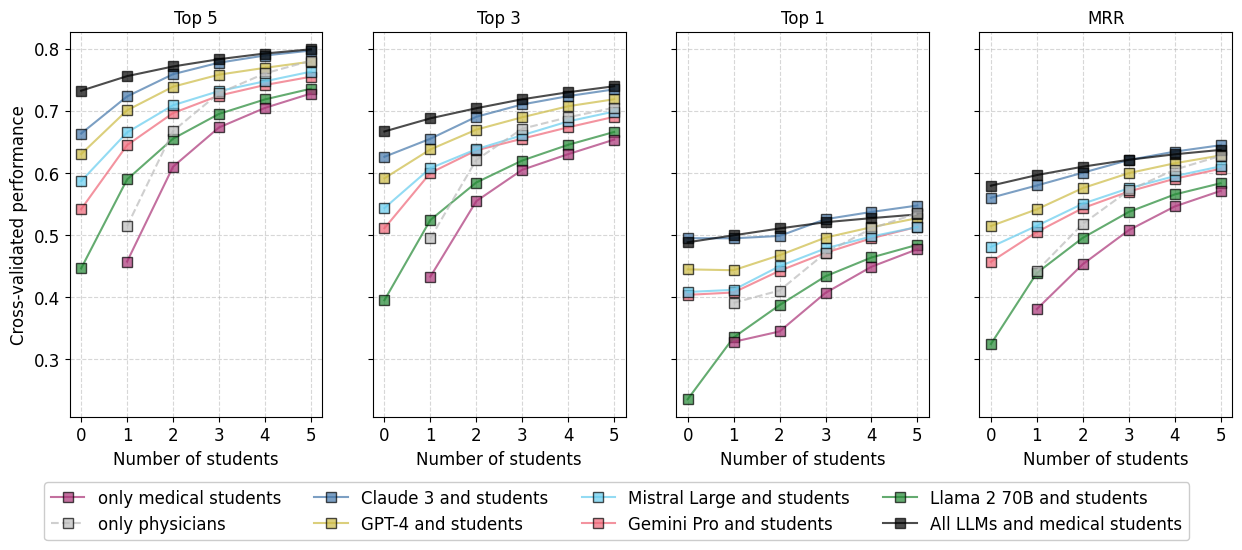

In [ ]:
# Filter the hybrid_collective_df DataFrame to include only cases relevant to selected medical students
hybrid_collective_df_sample_means_prof_studentcases = hybrid_collective_df[
    hybrid_collective_df['pc_id'].isin(selectedcases_id_to_solves_medstudents_min5.keys())
].groupby(['case_specialty', 'metric', 'combo_key', 'fold', 'pc_id'])[['top1', 'top3', 'top5', 'mrr']].mean()

# Reset the index and calculate the mean for each metric and combination key
hybrid_collective_means_prof_studentcases = hybrid_collective_df_sample_means_prof_studentcases.reset_index().groupby(
    ['metric', 'combo_key']
)[['top1', 'top3', 'top5', 'mrr']].mean()

# Reset the index to prepare the DataFrame for further analysis or plotting
hybrid_collective_means_prof_studentcases.reset_index(inplace=True)


# Create a grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
plt.subplots_adjust(hspace=0.55, wspace=0.2)

# Define the list of interest combinations for plotting
of_interest = [
    'OpenAI_gpt-4-1106-preview',
    'GoogleAI_gemini-1.0-pro',
    'AnthropicAI_claude-3-opus-20240229',
    'MetaAI_llama-2-70b-f',
    'MistralAI_mistral-large-latest',
    '',  # Empty string represents only medical students
    'OpenAI_gpt-4-1106-preview + GoogleAI_gemini-1.0-pro + AnthropicAI_claude-3-opus-20240229 + MetaAI_llama-2-70b-f + MistralAI_mistral-large-latest', 
]

# Define corresponding colors for the interest combinations
colors_of_interest = [
    colors['OpenAI_gpt-4-1106-preview'],
    colors['GoogleAI_gemini-1.0-pro'],
    colors['AnthropicAI_claude-3-opus-20240229'],
    colors['MetaAI_llama-2-70b-f'],
    colors['MistralAI_mistral-large-latest'],
    colors['Med student'],  # Color for medical students
    'black',  # Color for the combination of all LLMs and medical students
]

# Metric labels for plot titles
metric_label_dict = {"top5": "Top 5", "top3": "Top 3", "top1": "Top 1", "mrr": "MRR"}

# Loop through each metric and plot the data
for j, metric in enumerate(["top5", "top3", "top1", "mrr"]):
    plt.sca(axes[j])  
    mean_dict = hybrid_collective_means_students[(hybrid_collective_means_students['metric'] == metric)].set_index('combo_key').T.to_dict()
    
    # Plot data for each combination of interest
    for i, m_list in enumerate(of_interest):
        if m_list != '':
            x = COLLECTIVE_SOLVERS_TO_TEST
            y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST]
            if m_list == 'OpenAI_gpt-4-1106-preview + GoogleAI_gemini-1.0-pro + AnthropicAI_claude-3-opus-20240229 + MetaAI_llama-2-70b-f + MistralAI_mistral-large-latest':
                plt.plot(x, y, ms="7", marker='s', linestyle='-', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7,
                         label='All LLMs and medical students')
            else:
                plt.plot(x, y, ms="7", marker='s', linestyle='-', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7, label=labels[m_list] + ' and students')
        else:
            x = COLLECTIVE_SOLVERS_TO_TEST[1:]
            y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST[1:]]
            plt.plot(x, y, ms="7", marker='s', linestyle='-', color=colors_of_interest[i], markeredgecolor='black', alpha=0.7, label='only medical students')
    
    # Customize x-ticks and grid
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.grid(axis='y', ls='--', alpha=0.5)
    plt.grid(axis='x', ls='--', alpha=0.5)
    plt.xlabel('Number of students')
    plt.title(metric_label_dict[metric], fontsize=12)

    # Add y-label for the first and last plots
    if j == 5 or j == 0:
        plt.ylabel('Cross-validated performance')

# Plot data for professionals on the same axes
for j, metric in enumerate(["top5", "top3", "top1", "mrr"]):
    plt.sca(axes[j])  
    m_list = ''
    mean_dict = hybrid_collective_means_prof_studentcases[(hybrid_collective_means_prof_studentcases['metric'] == metric)].set_index('combo_key').T.to_dict()
    x = COLLECTIVE_SOLVERS_TO_TEST[1:]
    y = [mean_dict[m_list + f" + {num_solvers} human solvers"][metric] for num_solvers in COLLECTIVE_SOLVERS_TO_TEST[1:]]
    plt.plot(x, y, ms="7", marker='s', linestyle='--', color=colors['Professional'], markeredgecolor='black', alpha=0.7, label='only physicians')

# Adjust the legend
handles, legend_labels = axes[0].get_legend_handles_labels()
order = [5, 7, 2, 0, 4, 1, 3, 6]  # Order of legend items
handles = [handles[idx] for idx in order]
legend_labels = [legend_labels[idx] for idx in order]
plt.legend(handles, legend_labels, framealpha=1.0, ncol=4, loc=(-3.7, -0.32))

# Save the figure
plt.savefig(f'./plots_nature/acc_metricgrid_weightedLLMsStudents.png', bbox_inches='tight', format="png", dpi=300)

# Show the plot
plt.show()


# Confusion/agreement matrices

In [28]:
## Confusion matrices for diagnosticians giving the correct answer

# Define specific combinations of interest
single_combos = [
    ' + 1 human solvers', 
    ' + 5 human solvers',
    'OpenAI_gpt-4-1106-preview + 0 human solvers',
    'MistralAI_mistral-large-latest + 0 human solvers',
    'GoogleAI_gemini-1.0-pro + 0 human solvers',
    'AnthropicAI_claude-3-opus-20240229 + 0 human solvers',
    'MetaAI_llama-2-70b-f + 0 human solvers'
]

# Filter the DataFrame for specific combinations and metric 'mrr'
confusion_df = hybrid_collective_df[(hybrid_collective_df['metric'] == 'mrr') & (hybrid_collective_df['combo_key'].isin(single_combos))]

# Define solvers and LLM models
solvers = [' + 1 human solvers', ' + 5 human solvers']
llm_models = [
    'OpenAI_gpt-4-1106-preview + 0 human solvers',
    'MistralAI_mistral-large-latest + 0 human solvers',
    'GoogleAI_gemini-1.0-pro + 0 human solvers',
    'AnthropicAI_claude-3-opus-20240229 + 0 human solvers',
    'MetaAI_llama-2-70b-f + 0 human solvers'
]

# Initialize confusion matrices dictionary and position mapping
confusion_mats = {}
pos_dict = {-1: 0, 0: 5, 1: 4, 2: 3, 3: 2, 4: 1}
positions = [-1, 0, 1, 2, 3, 4]

# Compare solvers with LLM models
for solver in solvers:
    for llm_model in llm_models:
        key_str = llm_model.split('+')[0].strip() + ' vs ' + solver.split('+')[-1].strip()
        confusion_mats[key_str] = np.zeros((6, 6))
        filtered_confusion_df = confusion_df[(confusion_df['combo_key'].isin([llm_model, solver]))]
        
        for fold in range(5):
            fold_df = filtered_confusion_df[filtered_confusion_df['fold'] == fold]
            llm_fold_df = fold_df[fold_df['combo_key'] == llm_model]
            solver_fold_df = fold_df[fold_df['combo_key'] == solver]

            for case_id in tqdm(llm_fold_df['pc_id'].unique()):
                llm_model_rank = llm_fold_df[llm_fold_df['pc_id'] == case_id]['match_pos'].values[0]

                solver_filtered = solver_fold_df[solver_fold_df['pc_id'] == case_id]
                value_counts = solver_filtered['match_pos'].value_counts(normalize=True)

                for rank, score in value_counts.items():
                    confusion_mats[key_str][pos_dict[llm_model_rank]][pos_dict.get(rank, 0)] += score

        # Normalize the confusion matrix to percentage
        confusion_mats[key_str] = confusion_mats[key_str] / np.sum(confusion_mats[key_str]) * 100

# Compare LLM models with each other
for solver in llm_models:
    for llm_model in llm_models:
        if llm_model != solver:
            key_str = llm_model.split('+')[0].strip() + ' vs ' + solver.split('+')[0].strip()
            confusion_mats[key_str] = np.zeros((6, 6))
            filtered_confusion_df = confusion_df[(confusion_df['combo_key'].isin([llm_model, solver]))]
            
            for fold in range(5):
                fold_df = filtered_confusion_df[filtered_confusion_df['fold'] == fold]
                llm_fold_df = fold_df[fold_df['combo_key'] == llm_model]
                solver_fold_df = fold_df[fold_df['combo_key'] == solver]

                for case_id in tqdm(llm_fold_df['pc_id'].unique()):
                    llm_model_rank = llm_fold_df[llm_fold_df['pc_id'] == case_id]['match_pos'].values[0]

                    solver_filtered = solver_fold_df[solver_fold_df['pc_id'] == case_id]
                    value_counts = solver_filtered['match_pos'].value_counts(normalize=True)

                    for rank, score in value_counts.items():
                        confusion_mats[key_str][pos_dict[llm_model_rank]][pos_dict.get(rank, 0)] += score

            # Normalize the confusion matrix to percentage
            confusion_mats[key_str] = confusion_mats[key_str] / np.sum(confusion_mats[key_str]) * 100


  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

In [29]:
# Define solvers and LLM models
solvers = [' + 1 human solvers', ' + 5 human solvers']
llm_models = [
    'OpenAI_gpt-4-1106-preview + 0 human solvers',
    'MistralAI_mistral-large-latest + 0 human solvers',
    'GoogleAI_gemini-1.0-pro + 0 human solvers',
    'AnthropicAI_claude-3-opus-20240229 + 0 human solvers',
    'MetaAI_llama-2-70b-f + 0 human solvers'
]

# Initialize confusion matrices for correlation and normalization
confusion_mats_errors_corr = {}
confusion_mats_all_corr = {}
confusion_mats_onetrue_corr = {}
confusion_mats_errors_normalization = {}
confusion_mats_all_normalization = {}
confusion_mats_onetrue_normalization = {}

# Position mapping
pos_dict = {-1: 0, 0: 5, 1: 4, 2: 3, 3: 2, 4: 1}
positions = [-1, 0, 1, 2, 3, 4]

# Compare solvers with LLM models
for solver in solvers:
    for llm_model in llm_models:
        key_str = llm_model.split('+')[0].strip() + ' vs ' + solver.split('+')[-1].strip()
        
        # Initialize confusion matrices for each key
        confusion_mats_all_corr[key_str] = np.zeros((5, 5))
        confusion_mats_errors_corr[key_str] = np.zeros((5, 5))
        confusion_mats_onetrue_corr[key_str] = np.zeros((5, 5))
        confusion_mats_errors_normalization[key_str] = np.zeros((5, 5))
        confusion_mats_all_normalization[key_str] = np.zeros((5, 5))
        confusion_mats_onetrue_normalization[key_str] = np.zeros((5, 5))
        
        # Filter the DataFrame for relevant combinations
        filtered_confusion_df = confusion_df[(confusion_df['combo_key'].isin([llm_model, solver]))]
        
        # Iterate through each fold
        for fold in range(5):
            fold_df = filtered_confusion_df[filtered_confusion_df['fold'] == fold]
            llm_fold_df = fold_df[fold_df['combo_key'] == llm_model]
            solver_fold_df = fold_df[fold_df['combo_key'] == solver]

            # Iterate through each unique case ID
            for case_id in tqdm(llm_fold_df['pc_id'].unique()):
                llm_model_match_pos = llm_fold_df[llm_fold_df['pc_id'] == case_id]['match_pos'].values[0]
                llm_solution = llm_fold_df[llm_fold_df['pc_id'] == case_id]['final_dxs'].values[0]

                solver_filtered = solver_fold_df[solver_fold_df['pc_id'] == case_id]
                solver_solutions = solver_filtered.final_dxs
                solver_match_positions = solver_filtered.match_pos
                norm_solver_error = 1 / len(solver_solutions)
                
                for sol_match_pos, solution in zip(solver_match_positions, solver_solutions):
                    for rank_solver, diagnosis_solver in enumerate(solution[:5]):
                        for rank_llm, diagnosis_llm in enumerate(llm_solution[:5]):
                            confusion_mats_all_normalization[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                            if llm_model_match_pos == -1 and sol_match_pos == -1:
                                confusion_mats_errors_normalization[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                if diagnosis_solver == diagnosis_llm:
                                    confusion_mats_errors_corr[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                    confusion_mats_all_corr[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                            else:
                                confusion_mats_onetrue_normalization[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                if diagnosis_solver == diagnosis_llm:
                                    confusion_mats_onetrue_corr[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                    confusion_mats_all_corr[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error

# Update solvers and LLM models for LLM vs LLM comparisons
solvers = [
    'OpenAI_gpt-4-1106-preview + 0 human solvers',
    'MistralAI_mistral-large-latest + 0 human solvers',
    'GoogleAI_gemini-1.0-pro + 0 human solvers',
    'AnthropicAI_claude-3-opus-20240229 + 0 human solvers',
    'MetaAI_llama-2-70b-f + 0 human solvers'
]
llm_models = [
    'OpenAI_gpt-4-1106-preview + 0 human solvers',
    'MistralAI_mistral-large-latest + 0 human solvers',
    'GoogleAI_gemini-1.0-pro + 0 human solvers',
    'AnthropicAI_claude-3-opus-20240229 + 0 human solvers',
    'MetaAI_llama-2-70b-f + 0 human solvers'
]

# Compare LLM models with each other
for i, solver in enumerate(solvers):
    for llm_model in llm_models[i+1:]:
        key_str = llm_model.split('+')[0].strip() + ' vs ' + solver.split('+')[0].strip()
        
        # Initialize confusion matrices for each key
        confusion_mats_all_corr[key_str] = np.zeros((5, 5))
        confusion_mats_errors_corr[key_str] = np.zeros((5, 5))
        confusion_mats_onetrue_corr[key_str] = np.zeros((5, 5))
        confusion_mats_errors_normalization[key_str] = np.zeros((5, 5))
        confusion_mats_all_normalization[key_str] = np.zeros((5, 5))
        confusion_mats_onetrue_normalization[key_str] = np.zeros((5, 5))
        
        # Filter the DataFrame for relevant combinations
        filtered_confusion_df = confusion_df[(confusion_df['combo_key'].isin([llm_model, solver]))]
        
        # Iterate through each fold
        for fold in range(5):
            fold_df = filtered_confusion_df[filtered_confusion_df['fold'] == fold]
            llm_fold_df = fold_df[fold_df['combo_key'] == llm_model]
            solver_fold_df = fold_df[fold_df['combo_key'] == solver]

            # Iterate through each unique case ID
            for case_id in tqdm(llm_fold_df['pc_id'].unique()):
                llm_model_match_pos = llm_fold_df[llm_fold_df['pc_id'] == case_id]['match_pos'].values[0]
                llm_solution = llm_fold_df[llm_fold_df['pc_id'] == case_id]['final_dxs'].values[0]

                solver_filtered = solver_fold_df[solver_fold_df['pc_id'] == case_id]
                solver_solutions = solver_filtered.final_dxs
                solver_match_positions = solver_filtered.match_pos
                norm_solver_error = 1 / len(solver_solutions)
                
                for sol_match_pos, solution in zip(solver_match_positions, solver_solutions):
                    for rank_solver, diagnosis_solver in enumerate(solution[:5]):
                        for rank_llm, diagnosis_llm in enumerate(llm_solution[:5]):
                            confusion_mats_all_normalization[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                            if llm_model_match_pos == -1 and sol_match_pos == -1:
                                confusion_mats_errors_normalization[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                if diagnosis_solver == diagnosis_llm:
                                    confusion_mats_errors_corr[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                    confusion_mats_all_corr[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                            else:
                                confusion_mats_onetrue_normalization[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                if diagnosis_solver == diagnosis_llm:
                                    confusion_mats_onetrue_corr[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                    confusion_mats_all_corr[key_str][pos_dict[rank_llm] - 1][pos_dict[rank_solver] - 1] += norm_solver_error
                                    

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

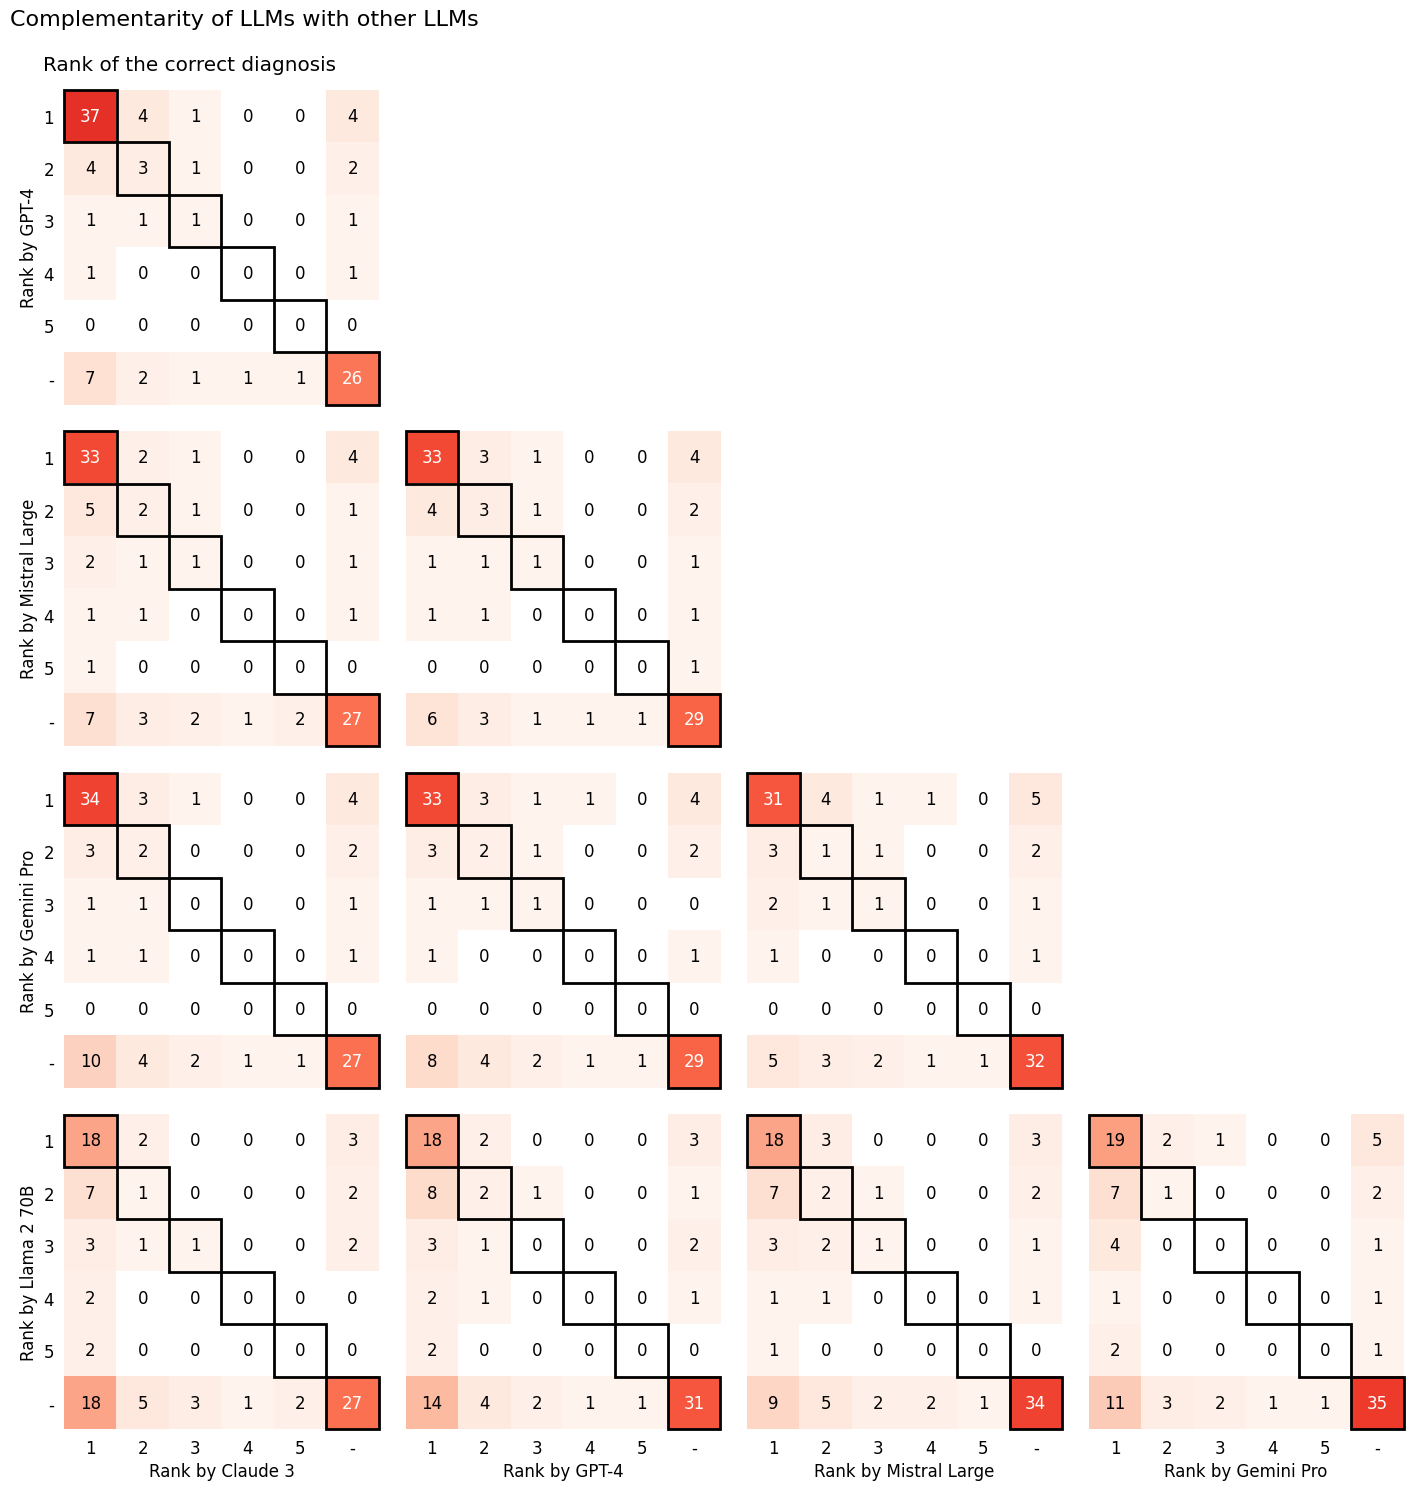

In [30]:
# Define model keys and generate combinations
model_keys = [
    'AnthropicAI_claude-3-opus-20240229',
    'OpenAI_gpt-4-1106-preview',
    'MistralAI_mistral-large-latest',
    'GoogleAI_gemini-1.0-pro',
    'MetaAI_llama-2-70b-f',
]
combis = list(combinations(model_keys, 2))

# Create the figure and grid for subplots
fig = plt.figure(figsize=(15, 15))
gs0 = gridspec.GridSpec(4, 4, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

# Get the Reds colormap
reds = plt.get_cmap('Reds')

# Create a linear segmented colormap
colors = [(1, 1, 1), *reds(np.linspace(0, 1, 256))]  # Starting with white
custom_cmap = LinearSegmentedColormap.from_list('custom_reds', colors)
custom_cmap.set_bad(color='white') 

# Normalize to your data range
norm = Normalize(vmin=0, vmax=56)

# Loop through each combination of model keys
for i in range(5):
    for j in range(5):
        if j < i:
            # Add subplot to the figure
            ax = fig.add_subplot(gs0[i-1, j])
            plt.sca(ax)
            
            # Generate key strings for matrix lookup
            key = ' vs '.join((model_keys[i], model_keys[j]))
            rev_key = ' vs '.join((model_keys[j], model_keys[i]))
            
            # Get the confusion matrix
            if key in confusion_mats:
                matrix = confusion_mats[key]
            elif rev_key in confusion_mats and j < i:
                matrix = confusion_mats[rev_key]
            
            # Flip and round the matrix
            matrix = np.fliplr(np.flipud(matrix))
            matrix = round_matrix_to_sum(matrix)

            # Display the matrix using imshow
            plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=56)
            
            # Set labels and titles
            if i == 1:
                plt.ylabel(f'Rank by {labels[key.split(" vs ")[1]]}')
                plt.title('Rank of the correct diagnosis', loc='left', x=-0.05, pad=10)
                plt.text(-0.15, 1.2, 'Complementarity of LLMs with other LLMs', ha='left', va='center', transform=plt.gca().transAxes, fontsize=16)
            if j == 0:
                ylabel = labels[model_keys[i]]
                plt.ylabel(f'Rank by {ylabel}')
            if i == 4:
                xlabel = labels[model_keys[j]]
                plt.xlabel(f'Rank by {xlabel}')
            
            # Hide tick labels for inner plots
            if j > 0:
                plt.setp(ax.get_yticklabels(), visible=False)
            if i < 4:
                plt.setp(ax.get_xticklabels(), visible=False)

            # Annotate the matrix with values
            for (k, l), val in np.ndenumerate(matrix):
                color = 'white' if matrix[k, l] > 25 else 'black'
                plt.text(l, k, f'{int(val)}', ha='center', va='center', color=color)
            
            # Add rectangles to the diagonal elements
            for k in range(min(matrix.shape)):
                rect = patches.Rectangle((k - 0.5, k - 0.5), 1, 1, linewidth=2, edgecolor='black', facecolor='none', zorder=5)
                ax.add_patch(rect)
            
            # Set axis limits and ticks
            plt.xlim((-0.6, 5.6))
            plt.ylim((5.6, -0.6))
            plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5, '-'])
            plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5, '-'])

            # Remove spines and ticks
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.tick_params(axis='both', which='both', length=0)
        else:
            try:
                if (1 <= i < 5) and (0 <= j < 4):
                    axes[i-1, j].axis('off')
            except:
                pass

# Save and show the plot
plt.savefig(f'./plots_nature/complementarity_LLMs_LLMs.png', bbox_inches='tight', format="png", dpi=300)
plt.show()


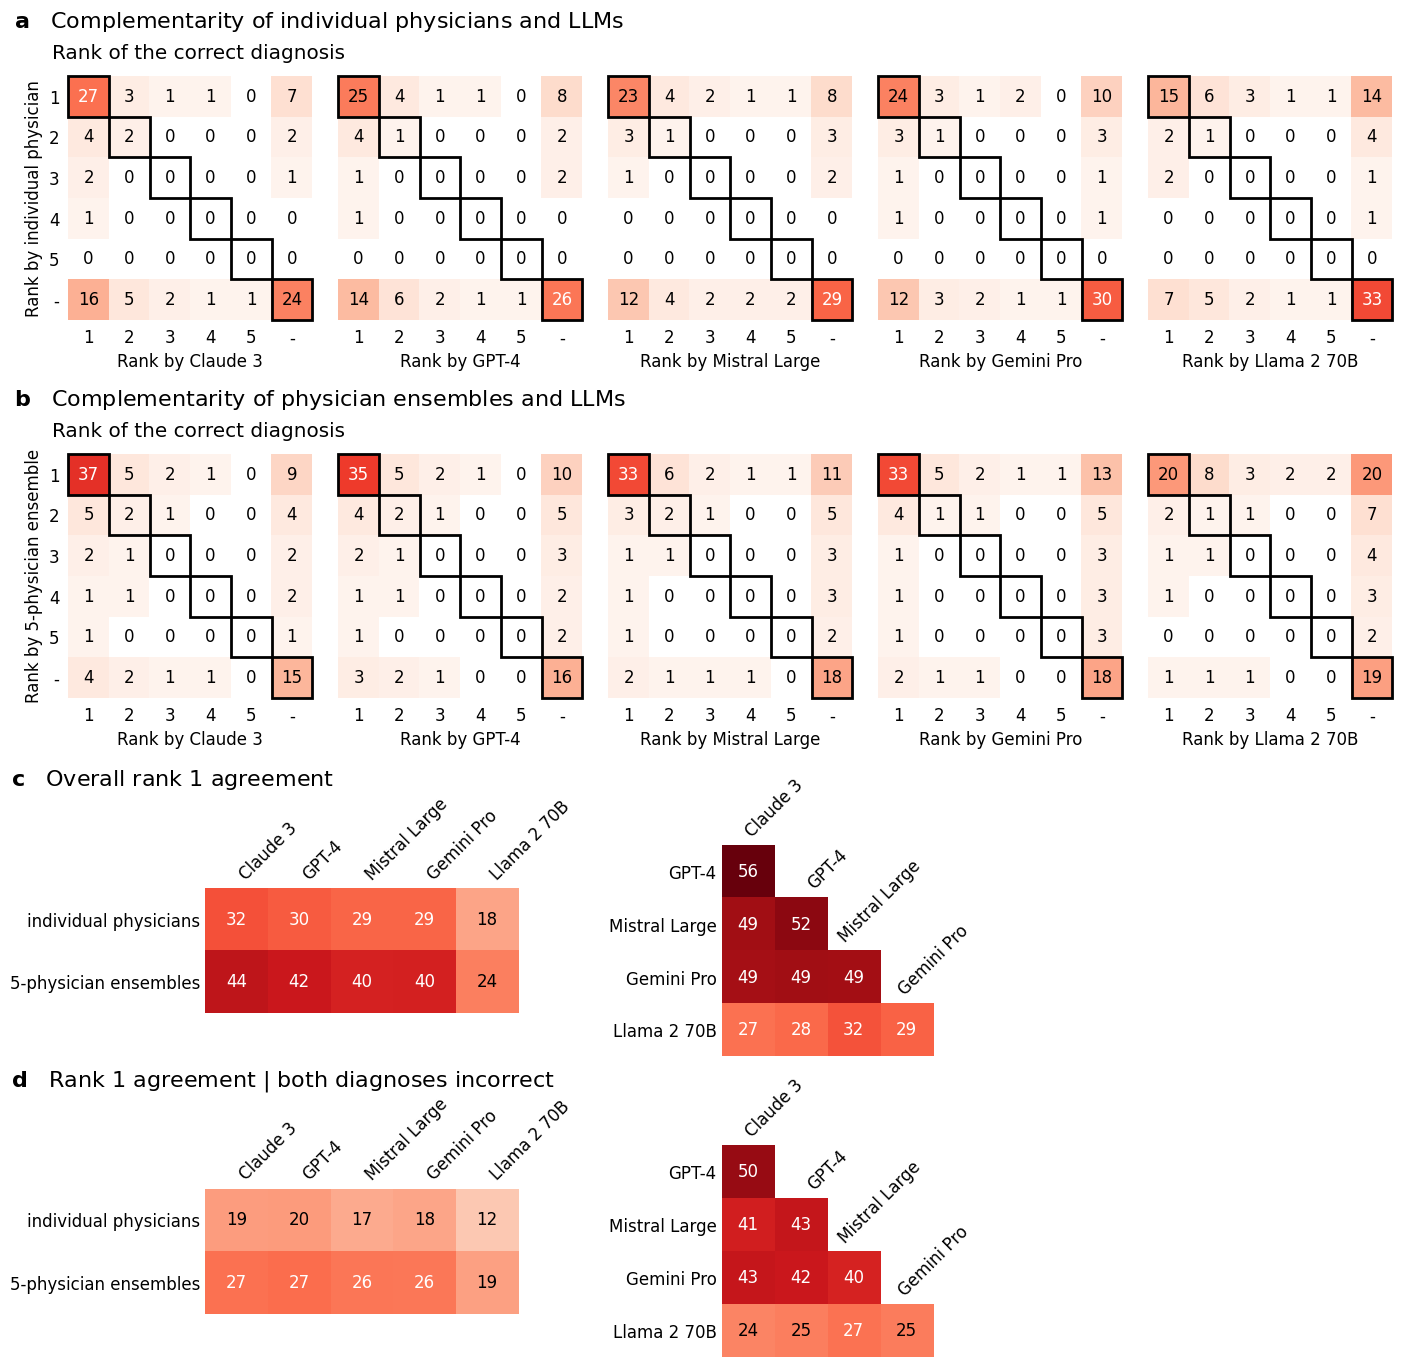

In [31]:
# Define colors and positions
reds = plt.get_cmap('Reds')
colors = [(1, 1, 1), *reds(np.linspace(0, 1, 256))]  # Starting with white
custom_cmap = LinearSegmentedColormap.from_list('custom_reds', colors)
custom_cmap.set_bad(color='white')
norm = Normalize(vmin=0, vmax=56)

keys = [
    'AnthropicAI_claude-3-opus-20240229 vs 1 human solvers',
    'OpenAI_gpt-4-1106-preview vs 1 human solvers',
    'MistralAI_mistral-large-latest vs 1 human solvers',
    'GoogleAI_gemini-1.0-pro vs 1 human solvers',
    'MetaAI_llama-2-70b-f vs 1 human solvers'
]

# Create the figure and grid for subplots
fig = plt.figure(figsize=(15, 14))
gs0 = gridspec.GridSpec(2, 5, figure=fig)
gs1 = gridspec.GridSpec(2, 5, figure=fig, width_ratios=[1, 1, 1, 1.5, 1])
gs0.update(left=0.05, right=0.95, top=0.95, bottom=0.5, wspace=0, hspace=0.5)
gs1.update(left=0.15, right=0.75, top=0.42, bottom=0.01, wspace=0.2, hspace=0.1)

# Plot correct rank for individual physicians and LLMs
for i, key in enumerate(keys):
    ax = fig.add_subplot(gs0[0, i])
    plt.sca(ax)
    matrix = confusion_mats[key]
    matrix = np.fliplr(np.flipud(matrix)).T
    matrix = round_matrix_to_sum(matrix)

    plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', norm=norm)

    plt.xlabel(f'Rank by {labels[key.split(" vs ")[0]]}')
    if i == 0:
        plt.ylabel(f'Rank by {labels[key.split(" vs ")[1]]}')
        plt.title('Rank of the correct diagnosis', loc='left', x=-0.05, pad=10)
        plt.text(-0.2, 1.2, r'$\bf{a}$   Complementarity of individual physicians and LLMs', ha='left', va='center', transform=plt.gca().transAxes, fontsize=16)

    for (k, j), val in np.ndenumerate(matrix):
        color = 'white' if matrix[k, j] > 25 else 'black'
        plt.text(j, k, f'{int(val)}', ha='center', va='center', color=color)

    for k in range(min(matrix.shape)):
        rect = patches.Rectangle((k - 0.5, k - 0.5), 1, 1, linewidth=2, edgecolor='black', facecolor='none', zorder=5)
        ax.add_patch(rect)

    plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5, '-'])
    plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5, '-'])
    if i != 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.xlim((-0.6, 5.6))
    plt.ylim((5.6, -0.6))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tick_params(axis='both', which='both', length=0)

# Plot correct rank for physician ensembles and LLMs
keys = [
    'AnthropicAI_claude-3-opus-20240229 vs 5 human solvers',
    'OpenAI_gpt-4-1106-preview vs 5 human solvers',
    'MistralAI_mistral-large-latest vs 5 human solvers',
    'GoogleAI_gemini-1.0-pro vs 5 human solvers',
    'MetaAI_llama-2-70b-f vs 5 human solvers'
]

for i, key in enumerate(keys):
    ax = fig.add_subplot(gs0[1, i])
    plt.sca(ax)
    matrix = confusion_mats[key]
    matrix = np.fliplr(np.flipud(matrix)).T
    matrix = round_matrix_to_sum(matrix)
    plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', norm=norm)

    plt.xlabel(f'Rank by {labels[key.split(" vs ")[0]]}')
    if i == 0:
        plt.ylabel(f'Rank by {labels[key.split(" vs ")[1]]}')
        plt.title('Rank of the correct diagnosis', loc='left', x=-0.05, pad=10)
        plt.text(-0.2, 1.2, r'$\bf{b}$   Complementarity of physician ensembles and LLMs', ha='left', va='center', transform=plt.gca().transAxes, fontsize=16)

    for (k, j), val in np.ndenumerate(matrix):
        color = 'white' if matrix[k, j] > 25 else 'black'
        plt.text(j, k, f'{int(val)}', ha='center', va='center', color=color)

    for k in range(min(matrix.shape)):
        rect = patches.Rectangle((k - 0.5, k - 0.5), 1, 1, linewidth=2, edgecolor='black', facecolor='none', zorder=5)
        ax.add_patch(rect)

    plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5, '-'])
    plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5, '-'])
    if i != 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.xlim((-0.6, 5.6))
    plt.ylim((5.6, -0.6))

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tick_params(axis='both', which='both', length=0)

# Plot rank 1 agreement for incorrect diagnoses
ax = fig.add_subplot(gs1[1, 0:2])
plt.sca(ax)
rank1_matrix = np.zeros((2, 5))
keys = [
    'AnthropicAI_claude-3-opus-20240229 vs 1 human solvers',
    'OpenAI_gpt-4-1106-preview vs 1 human solvers',
    'MistralAI_mistral-large-latest vs 1 human solvers',
    'GoogleAI_gemini-1.0-pro vs 1 human solvers',
    'MetaAI_llama-2-70b-f vs 1 human solvers'
]

for i, key in enumerate(keys):
    if key in confusion_mats_errors_corr:
        rank1_matrix[0][i] = confusion_mats_errors_corr[key][4][4] / confusion_mats_errors_normalization[key][4][4] * 100

keys = [
    'AnthropicAI_claude-3-opus-20240229 vs 5 human solvers',
    'OpenAI_gpt-4-1106-preview vs 5 human solvers',
    'MistralAI_mistral-large-latest vs 5 human solvers',
    'GoogleAI_gemini-1.0-pro vs 5 human solvers',
    'MetaAI_llama-2-70b-f vs 5 human solvers'
]

for i, key in enumerate(keys):
    if key in confusion_mats_errors_corr:
        rank1_matrix[1][i] = confusion_mats_errors_corr[key][4][4] / confusion_mats_errors_normalization[key][4][4] * 100

masked_matrix = np.ma.masked_where(rank1_matrix == 0, rank1_matrix)
plt.imshow(masked_matrix, cmap=custom_cmap, interpolation='nearest', norm=norm, aspect='equal')

plt.title(r'$\bf{d}$   Rank 1 agreement | both diagnoses incorrect', loc='left', x=-0.62, fontsize=16)

for (i, j), val in np.ndenumerate(rank1_matrix):
    if val > 0:
        color = 'white' if rank1_matrix[i, j] > 25 else 'black'
        plt.text(j, i, f'{int(np.round(val))}', ha='center', va='center', color=color)

plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
xlabels = [labels[key.split(" vs ")[0]] for key in keys]
ax.set_xticks(ticks=[0, 1, 2, 3, 4], labels=xlabels, rotation=45, ha='left')
ax.set_yticks(ticks=[0, 1], labels=['individual physicians', '5-physician ensembles'])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tick_params(axis='both', which='both', length=0)

# Plot overall rank 1 agreement
ax = fig.add_subplot(gs1[0, 0:2])
plt.sca(ax)
rank1_matrix = np.zeros((2, 5))
keys = [
    'AnthropicAI_claude-3-opus-20240229 vs 1 human solvers',
    'OpenAI_gpt-4-1106-preview vs 1 human solvers',
    'MistralAI_mistral-large-latest vs 1 human solvers',
    'GoogleAI_gemini-1.0-pro vs 1 human solvers',
    'MetaAI_llama-2-70b-f vs 1 human solvers'
]

for i, key in enumerate(keys):
    if key in confusion_mats_onetrue_corr:
        rank1_matrix[0][i] = confusion_mats_all_corr[key][4][4] / confusion_mats_all_normalization[key][4][4] * 100

keys = [
    'AnthropicAI_claude-3-opus-20240229 vs 5 human solvers',
    'OpenAI_gpt-4-1106-preview vs 5 human solvers',
    'MistralAI_mistral-large-latest vs 5 human solvers',
    'GoogleAI_gemini-1.0-pro vs 5 human solvers',
    'MetaAI_llama-2-70b-f vs 5 human solvers'
]

for i, key in enumerate(keys):
    if key in confusion_mats_onetrue_corr:
        rank1_matrix[1][i] = confusion_mats_all_corr[key][4][4] / confusion_mats_all_normalization[key][4][4] * 100

masked_matrix = np.ma.masked_where(rank1_matrix == 0, rank1_matrix)
plt.imshow(masked_matrix, cmap=custom_cmap, interpolation='nearest', norm=norm, aspect='equal')

plt.title(r'$\bf{c}$   Overall rank 1 agreement', loc='left', x=-0.62, fontsize=16)

for (i, j), val in np.ndenumerate(rank1_matrix):
    if val > 0:
        color = 'white' if rank1_matrix[i, j] > 25 else 'black'
        plt.text(j, i, f'{int(np.round(val))}', ha='center', va='center', color=color)

plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
xlabels = [labels[key.split(" vs ")[0]] for key in keys]
ax.set_xticks(ticks=[0, 1, 2, 3, 4], labels=xlabels, rotation=45, ha='left')
ax.set_yticks(ticks=[0, 1], labels=['individual physicians', '5-physician ensembles'])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tick_params(axis='both', which='both', length=0)

# Plot rank 1 agreement for LLMs where both are incorrect
ax = fig.add_subplot(gs1[1, 3:4])
plt.sca(ax)
rank1_matrix = np.zeros((4, 4))
keys = [
    'AnthropicAI_claude-3-opus-20240229',
    'OpenAI_gpt-4-1106-preview',
    'MistralAI_mistral-large-latest',
    'GoogleAI_gemini-1.0-pro',
    'MetaAI_llama-2-70b-f'
]

for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if key1 != key2:
            key = ' vs '.join((key1, key2))
            rev_key = ' vs '.join((key2, key1))
            if key in confusion_mats_errors_corr:
                rank1_matrix[i-1][j] = confusion_mats_errors_corr[key][4][4] / confusion_mats_errors_normalization[key][4][4] * 100
            elif rev_key in confusion_mats_errors_corr and j < i:
                rank1_matrix[i-1][j] = confusion_mats_errors_corr[rev_key][4][4] / confusion_mats_errors_normalization[rev_key][4][4] * 100

masked_matrix = np.ma.masked_where(rank1_matrix == 0, rank1_matrix)
plt.imshow(masked_matrix, cmap=custom_cmap, interpolation='nearest', norm=norm, aspect='equal')

for (i, j), val in np.ndenumerate(rank1_matrix):
    if val > 0:
        color = 'white' if rank1_matrix[i, j] > 25 else 'black'
        plt.text(j, i, f'{int(round(val))}', ha='center', va='center', color=color)

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[labels[key.split(" vs ")[0]] for key in keys[:4]], rotation=45)
ax.set_yticks(ticks=[0, 1, 2, 3], labels=[labels[key.split(" vs ")[0]] for key in keys[1:]])
xtick_labels = ax.get_xticklabels()
for n, tick in enumerate(xtick_labels):
    tick.set_y(tick.get_position()[1] - 0.25 * n)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0)

# Plot overall rank 1 agreement for LLMs
ax = fig.add_subplot(gs1[0, 3:4])
plt.sca(ax)
rank1_matrix = np.zeros((4, 4))

for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if key1 != key2:
            key = ' vs '.join((key1, key2))
            rev_key = ' vs '.join((key2, key1))
            if key in confusion_mats_errors_corr:
                rank1_matrix[i-1][j] = confusion_mats_all_corr[key][4][4] / confusion_mats_all_normalization[key][4][4] * 100
            elif rev_key in confusion_mats_errors_corr and j < i:
                rank1_matrix[i-1][j] = confusion_mats_all_corr[rev_key][4][4] / confusion_mats_all_normalization[rev_key][4][4] * 100

masked_matrix = np.ma.masked_where(rank1_matrix == 0, rank1_matrix)
plt.imshow(masked_matrix, cmap=custom_cmap, interpolation='nearest', norm=norm, aspect='equal')

for (i, j), val in np.ndenumerate(rank1_matrix):
    if val > 0:
        color = 'white' if rank1_matrix[i, j] > 25 else 'black'
        plt.text(j, i, f'{int(round(val))}', ha='center', va='center', color=color)

plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[labels[key.split(" vs ")[0]] for key in keys[:4]], rotation=45)
ax.set_yticks(ticks=[0, 1, 2, 3], labels=[labels[key.split(" vs ")[0]] for key in keys[1:]])
xtick_labels = ax.get_xticklabels()
for n, tick in enumerate(xtick_labels):
    tick.set_y(tick.get_position()[1] - 0.25 * n)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0)

# Save and show the plot
plt.savefig(f'./plots_nature/complementarity_physicians_LLMs.png', bbox_inches='tight', format="png", dpi=300)
plt.show()


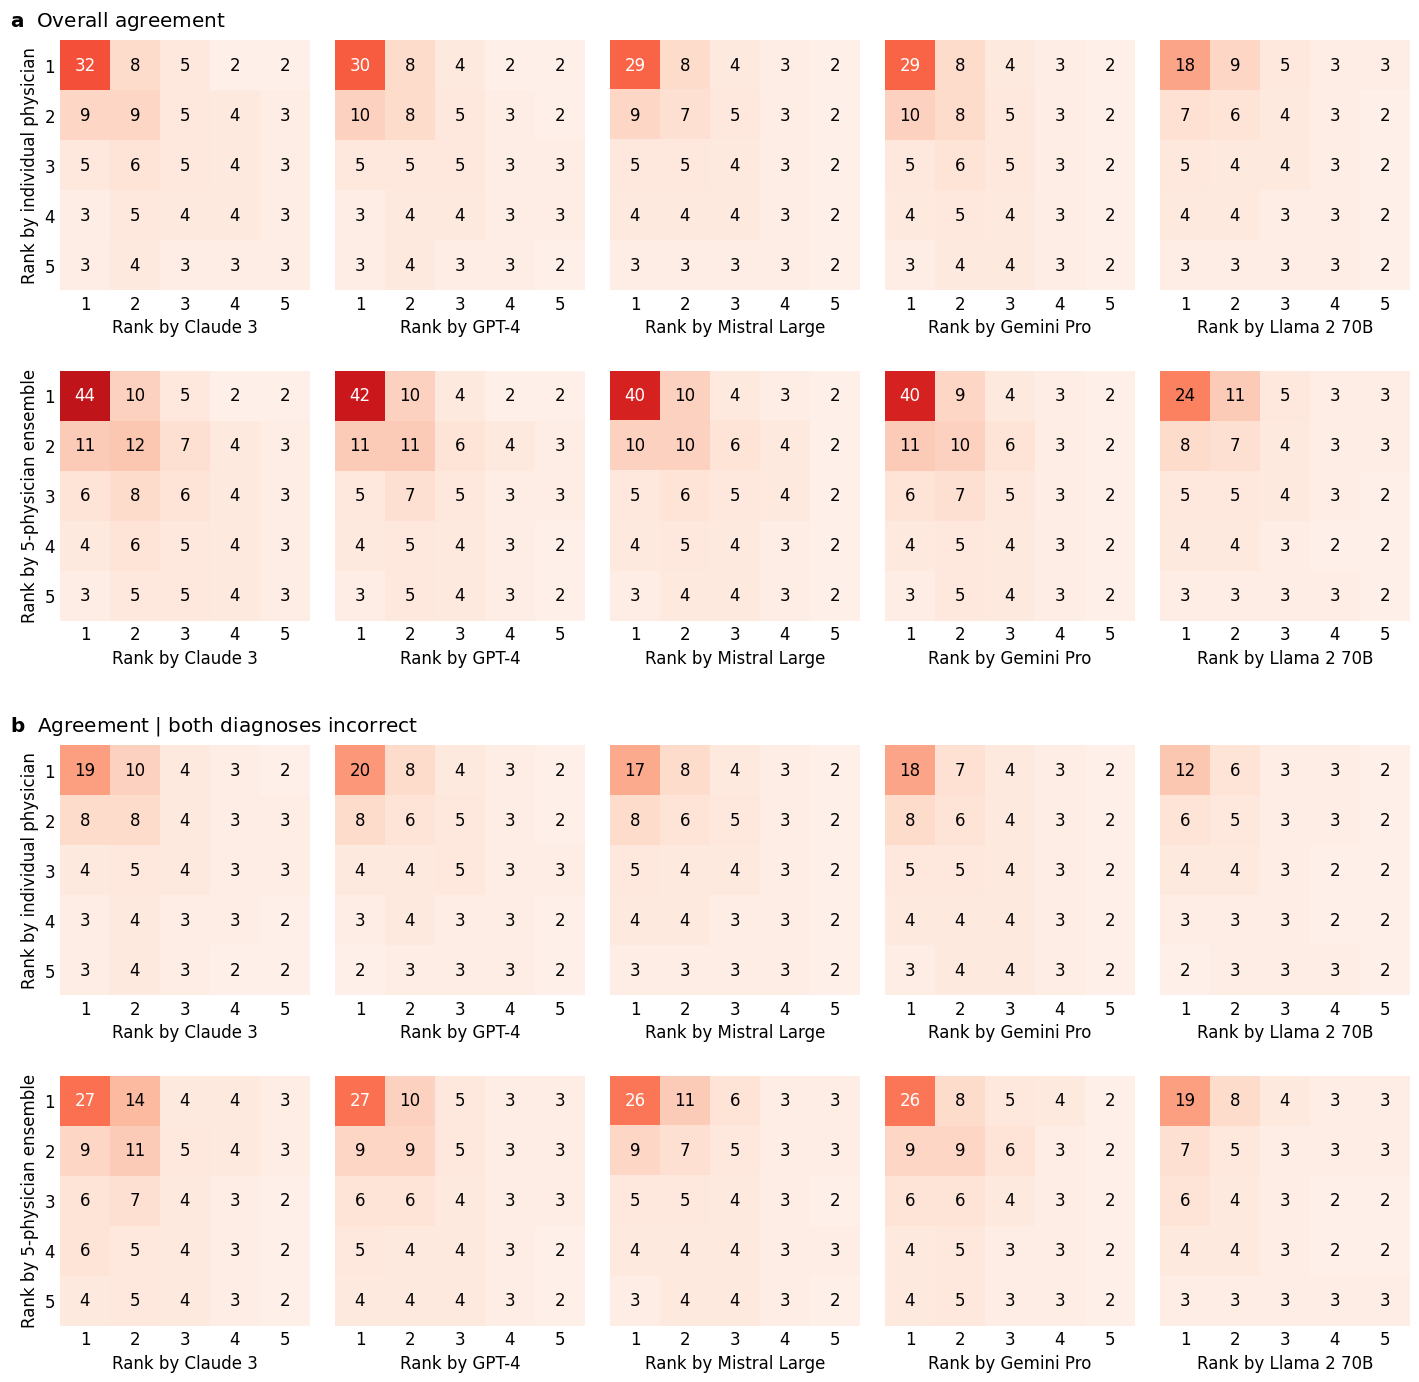

In [32]:
# Define the keys for comparisons
keys = [
    'AnthropicAI_claude-3-opus-20240229 vs 1 human solvers',
    'OpenAI_gpt-4-1106-preview vs 1 human solvers',
    'MistralAI_mistral-large-latest vs 1 human solvers',
    'GoogleAI_gemini-1.0-pro vs 1 human solvers',
    'MetaAI_llama-2-70b-f vs 1 human solvers'
]

# Create the figure and grid for subplots
fig = plt.figure(figsize=(15, 15))
gs0 = gridspec.GridSpec(2, 5, figure=fig)
gs1 = gridspec.GridSpec(2, 5, figure=fig)
gs0.update(left=0.05, right=0.95, top=0.95, bottom=0.52, wspace=0.1, hspace=0.05)
gs1.update(left=0.05, right=0.95, top=0.48, bottom=0.05, wspace=0.1, hspace=0.05)

# Plot the confusion matrices for individual LLMs vs 1 human solver
for i, key in enumerate(keys):
    ax = fig.add_subplot(gs1[0, i])
    plt.sca(ax)
    matrix = confusion_mats_errors_corr[key] / confusion_mats_errors_normalization[key] * 100
    matrix = np.fliplr(np.flipud(matrix)).T
    matrix = np.round(matrix)
    plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', norm=norm)
    
    plt.xlabel(f'Rank by {labels[key.split(" vs ")[0]]}')
    if i == 0:
        plt.ylabel(f'Rank by {labels[key.split(" vs ")[1]]}')
        plt.title(r'$\bf{b}$  Agreement | both diagnoses incorrect', loc='left', x=-0.2, pad=10)

    for (k, j), val in np.ndenumerate(matrix):
        color = 'white' if matrix[k, j] > 25 else 'black'
        plt.text(j, k, f'{int(val)}', ha='center', va='center', color=color)

    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
    plt.yticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
    if i != 0:
        plt.setp(ax.get_yticklabels(), visible=False)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tick_params(axis='both', which='both', length=0)

# Plot the overall confusion matrices for individual LLMs vs 1 human solver
for i, key in enumerate(keys):
    ax = fig.add_subplot(gs0[0, i])
    plt.sca(ax)
    matrix = confusion_mats_all_corr[key] / confusion_mats_all_normalization[key] * 100 
    matrix = np.fliplr(np.flipud(matrix)).T
    matrix = np.round(matrix)
    plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', norm=norm)
    
    plt.xlabel(f'Rank by {labels[key.split(" vs ")[0]]}')
    if i == 0:
        plt.ylabel(f'Rank by {labels[key.split(" vs ")[1]]}')
        plt.title(r'$\bf{a}$  Overall agreement', loc='left', x=-0.2, pad=10)

    for (k, j), val in np.ndenumerate(matrix):
        color = 'white' if matrix[k, j] > 25 else 'black'
        plt.text(j, k, f'{int(val)}', ha='center', va='center', color=color)

    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
    plt.yticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
    if i != 0:
        plt.setp(ax.get_yticklabels(), visible=False)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tick_params(axis='both', which='both', length=0)

# Define keys for comparisons with 5 human solvers
keys = [
    'AnthropicAI_claude-3-opus-20240229 vs 5 human solvers',
    'OpenAI_gpt-4-1106-preview vs 5 human solvers',
    'MistralAI_mistral-large-latest vs 5 human solvers',
    'GoogleAI_gemini-1.0-pro vs 5 human solvers',
    'MetaAI_llama-2-70b-f vs 5 human solvers'
]

# Plot the confusion matrices for individual LLMs vs 5 human solvers
for i, key in enumerate(keys):
    ax = fig.add_subplot(gs1[1, i])
    plt.sca(ax)
    matrix = confusion_mats_errors_corr[key] / confusion_mats_errors_normalization[key] * 100 
    matrix = np.fliplr(np.flipud(matrix)).T
    matrix = np.round(matrix)
    plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', norm=norm)

    plt.xlabel(f'Rank by {labels[key.split(" vs ")[0]]}')
    if i == 0:
        plt.ylabel(f'Rank by {labels[key.split(" vs ")[1]]}')

    for (k, j), val in np.ndenumerate(matrix):
        color = 'white' if matrix[k, j] > 25 else 'black'
        plt.text(j, k, f'{int(val)}', ha='center', va='center', color=color)

    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
    plt.yticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
    if i != 0:
        plt.setp(ax.get_yticklabels(), visible=False)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tick_params(axis='both', which='both', length=0)

# Plot the overall confusion matrices for individual LLMs vs 5 human solvers
for i, key in enumerate(keys):
    ax = fig.add_subplot(gs0[1, i])
    plt.sca(ax)
    matrix = confusion_mats_all_corr[key] / confusion_mats_all_normalization[key] * 100 
    matrix = np.fliplr(np.flipud(matrix)).T
    matrix = np.round(matrix)
    plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', norm=norm)

    plt.xlabel(f'Rank by {labels[key.split(" vs ")[0]]}')
    if i == 0:
        plt.ylabel(f'Rank by {labels[key.split(" vs ")[1]]}')

    for (k, j), val in np.ndenumerate(matrix):
        color = 'white' if matrix[k, j] > 25 else 'black'
        plt.text(j, k, f'{int(val)}', ha='center', va='center', color=color)

    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
    plt.yticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
    if i != 0:
        plt.setp(ax.get_yticklabels(), visible=False)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tick_params(axis='both', which='both', length=0)

# Save and show the plot
# plt.savefig(f'./plots_nature/agreement_physicians_LLMs_5x5.png', bbox_inches='tight', format="png", dpi=300)
plt.show()


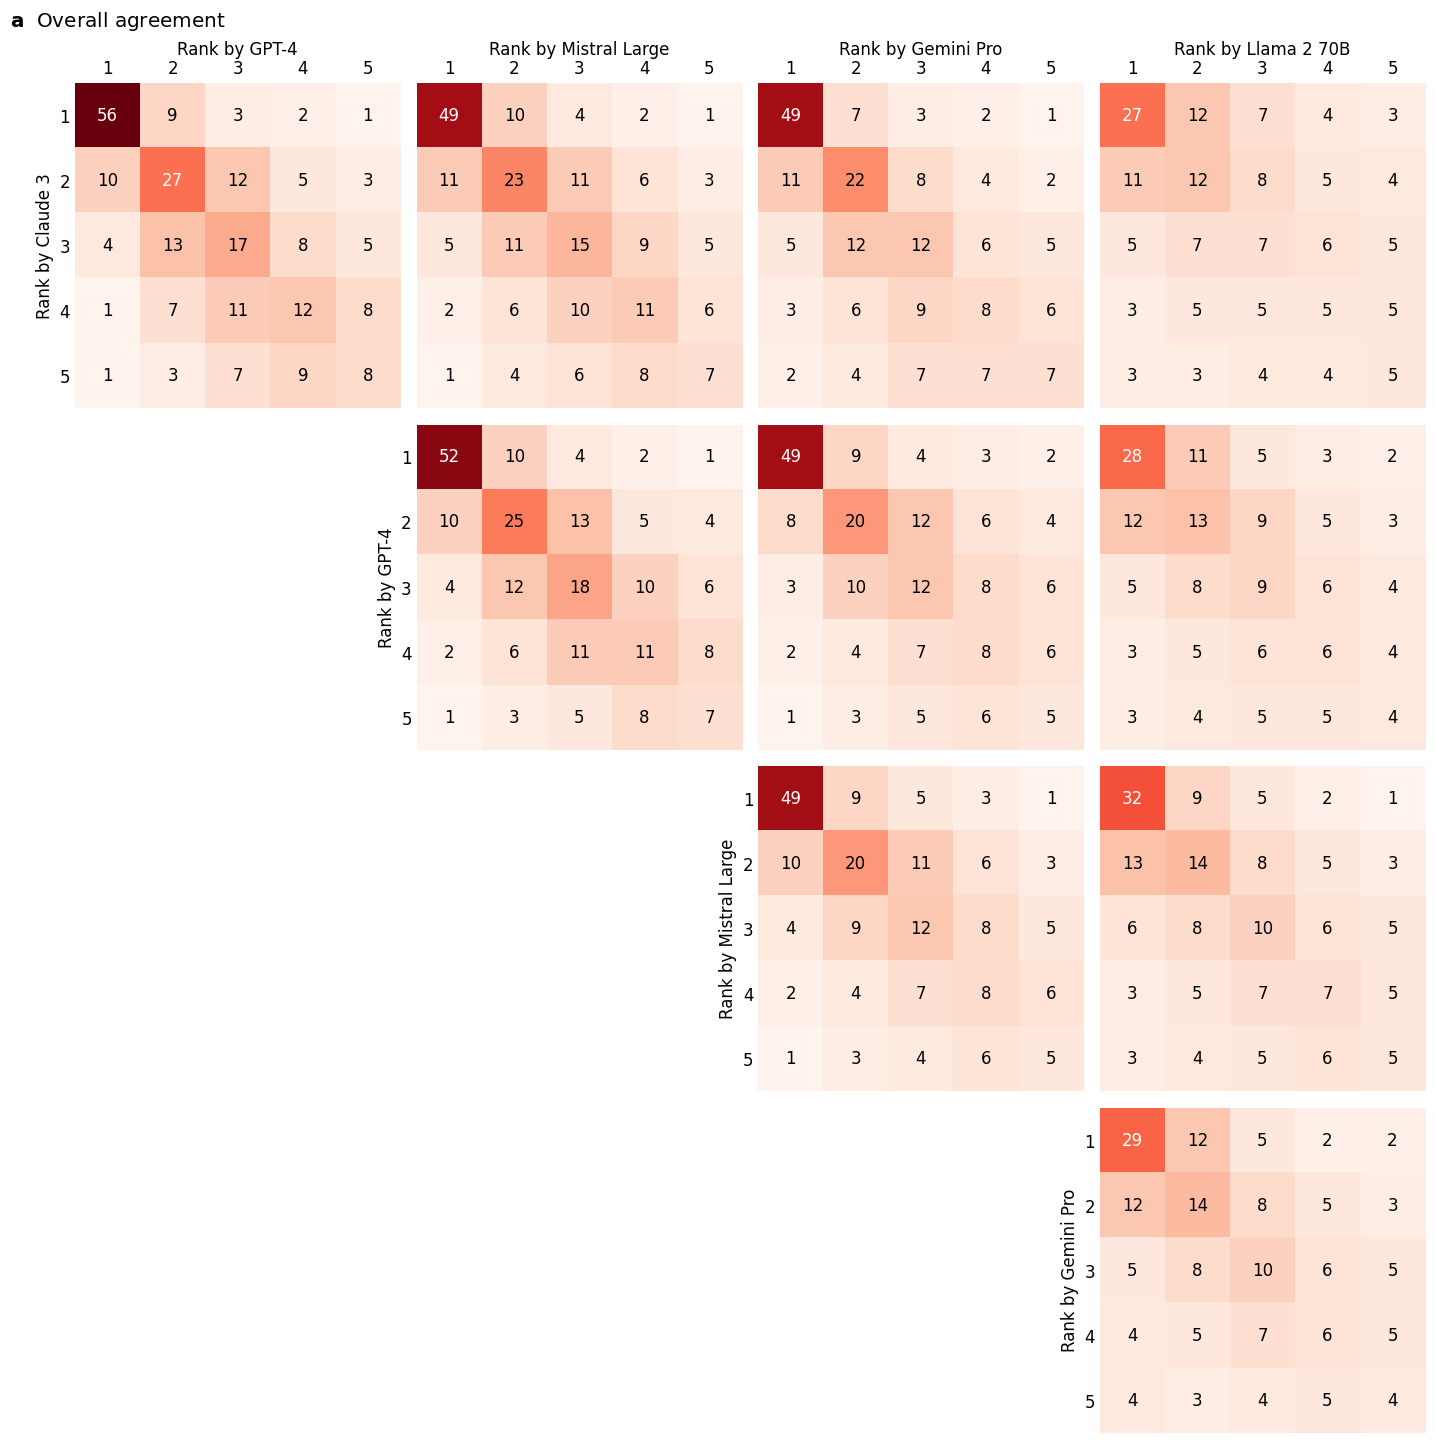

In [33]:
# Define model keys and generate combinations
model_keys = [
    'AnthropicAI_claude-3-opus-20240229',
    'OpenAI_gpt-4-1106-preview',
    'MistralAI_mistral-large-latest',
    'GoogleAI_gemini-1.0-pro',
    'MetaAI_llama-2-70b-f',
]
combis = list(combinations(model_keys, 2))

# Create the figure and grid for subplots
fig = plt.figure(figsize=(15, 15))
gs0 = gridspec.GridSpec(4, 4, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

# Loop through each combination of model keys
for i in range(5):
    for j in range(5):
        if j < i:
            # Add subplot to the figure
            ax = fig.add_subplot(gs0[j, i-1])
            ax.xaxis.set_label_position('top')
            plt.sca(ax)
            
            # Generate key strings for matrix lookup
            key = ' vs '.join((model_keys[i], model_keys[j]))
            rev_key = ' vs '.join((model_keys[j], model_keys[i]))

            # Get the confusion matrix and normalize it
            if key in confusion_mats_all_corr:
                matrix = confusion_mats_all_corr[key] / confusion_mats_all_normalization[key] * 100
            elif rev_key in confusion_mats_all_corr and j < i:
                matrix = confusion_mats_all_corr[rev_key] / confusion_mats_all_normalization[rev_key] * 100
            matrix = np.fliplr(np.flipud(matrix))
            matrix = np.round(matrix)

            # Display the matrix using imshow
            plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', norm=norm)
            plt.tick_params(axis='both', which='both', length=0, top=True, labeltop=True, bottom=False, labelbottom=False)
            plt.setp(ax.get_xticklabels(), visible=False)

            # Set the title for the first column
            if i == 1:
                plt.title(r'$\bf{a}$  Overall agreement', loc='left', x=-0.2, pad=10)
            
            # Set labels and titles
            if j == 0:
                xlabel = labels[model_keys[i]]
                plt.xlabel(f'Rank by {xlabel}')
                plt.setp(ax.get_xticklabels(), visible=True)
                ax.tick_params(labeltop=True)
            if i == j + 1:
                ylabel = labels[model_keys[j]]
                plt.ylabel(f'Rank by {ylabel}')
            if i != j + 1:
                plt.setp(ax.get_yticklabels(), visible=False)

            # Annotate the matrix with values
            for (k, l), val in np.ndenumerate(matrix):
                color = 'white' if matrix[k, l] > 25 else 'black'
                plt.text(l, k, f'{int(val)}', ha='center', va='center', color=color)

            # Set axis ticks and labels
            plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
            plt.yticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])

            # Remove spines for a cleaner look
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)

        else:
            try:
                if (1 <= i < 5) and (0 <= j < 4):
                    axes[i-1, j].axis('off')
            except:
                pass

# Save and show the plot
plt.savefig(f'./plots_nature/agreement_LLMs_LLMs_5x5a.png', bbox_inches='tight', transparent=True, format="png", dpi=300)
plt.show()


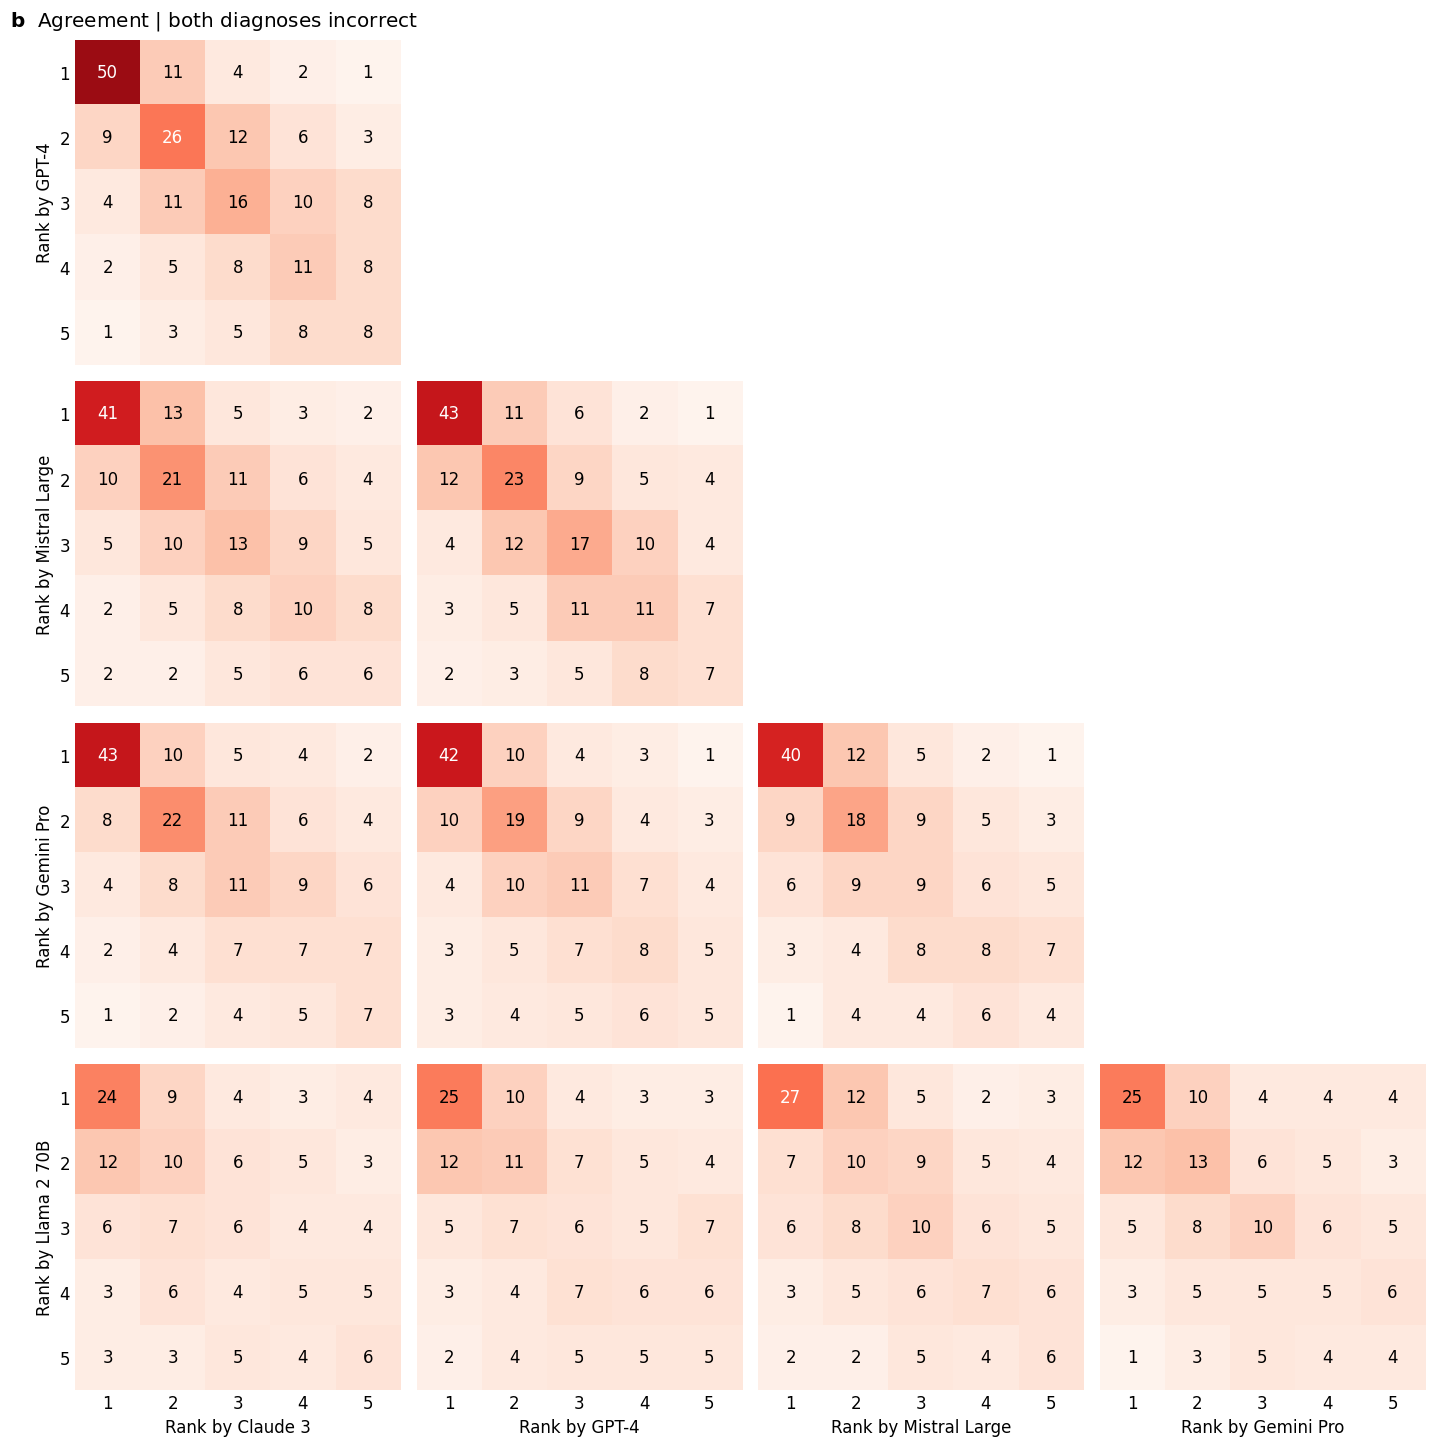

In [34]:
# Create the figure and grid for subplots
fig = plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(4, 4, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

# Loop through each combination of model keys
for i in range(5):
    for j in range(5):
        if j < i:
            # Add subplot to the figure
            ax = fig.add_subplot(gs1[i-1, j])
            plt.sca(ax)

            # Generate key strings for matrix lookup
            key = ' vs '.join((model_keys[i], model_keys[j]))
            rev_key = ' vs '.join((model_keys[j], model_keys[i]))

            # Get the confusion matrix and normalize it
            if key in confusion_mats_errors_corr:
                matrix = confusion_mats_errors_corr[key] / confusion_mats_errors_normalization[key] * 100
            elif rev_key in confusion_mats_errors_corr and j < i:
                matrix = confusion_mats_errors_corr[rev_key] / confusion_mats_errors_normalization[rev_key] * 100
            matrix = np.fliplr(np.flipud(matrix)).T
            matrix = np.round(matrix)

            # Display the matrix using imshow
            plt.imshow(matrix, cmap=custom_cmap, interpolation='nearest', norm=norm)
            
            # Set labels and titles
            if i == 1:
                plt.ylabel(f'Rank by {labels[key.split(" vs ")[1]]}')
                plt.title(r'$\bf{b}$  Agreement | both diagnoses incorrect', loc='left', x=-0.2, pad=10)
            if j == 0:
                ylabel = labels[model_keys[i]]
                plt.ylabel(f'Rank by {ylabel}')
            if i == 4:
                xlabel = labels[model_keys[j]]
                plt.xlabel(f'Rank by {xlabel}')
            if j > 0:
                plt.setp(ax.get_yticklabels(), visible=False)
            if i < 4:
                plt.setp(ax.get_xticklabels(), visible=False)

            # Annotate the matrix with values
            for (k, l), val in np.ndenumerate(matrix):
                color = 'white' if matrix[k, l] > 25 else 'black'
                plt.text(l, k, f'{int(val)}', ha='center', va='center', color=color)

            # Set axis ticks and labels
            plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
            plt.yticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])

            # Remove spines for a cleaner look
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.tick_params(axis='both', which='both', length=0)
        else:
            try:
                if (1 <= i < 5) and (0 <= j < 4):
                    axes[i-1, j].axis('off')
            except:
                pass

# Save and show the plot
plt.savefig(f'./plots_nature/agreement_LLMs_LLMs_5x5b.png', bbox_inches='tight', transparent=True, format="png", dpi=300)
plt.show()
